#NBEATS architecture

Contains the NBeats classes. This part of the code was developed by Philippe Remy taken from: 
https://github.com/philipperemy/n-beats

In [ ]:
!pip install 'statsmodels==0.11.1'

     |████████████████████████████████| 8.7MB 2.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
%matplotlib inline
import os

from torchsummary import summary 
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import numpy as np


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from torch import device as device_
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device('cuda:0')
plt.rcParams.update({'font.size': 22})

In [ ]:
class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    GENERIC_BLOCK = 'generic'

    def __init__(self,
                 device,
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 forecast_length=5,
                 backcast_length=10,
                 thetas_dims=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None):
        super(NBeatsNet, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dims
        self.parameters = []
        self.device = device
        #print(f'| N-Beats')
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        #print(f'| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})')
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(self.hidden_layer_units, self.thetas_dim[stack_id],
                                   self.device, self.backcast_length, self.forecast_length, self.nb_harmonics)
                self.parameters.extend(block.parameters())
            #print(f'     | -- {block}')
            blocks.append(block)
        return blocks

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def forward(self, backcast):
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
        return backcast, forecast


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= thetas.shape[1], 'thetas_dim is too big.'
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor([np.cos(2 * np.pi * i * t) for i in range(p1)]).float()  # H/2-1
    s2 = torch.tensor([np.sin(2 * np.pi * i * t) for i in range(p2)]).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, 'thetas_dim is too big.'
    T = torch.tensor([t ** i for i in range(p)]).float()
    return thetas.mm(T.to(device))


def linspace(backcast_length, forecast_length):
    lin_space = np.linspace(-backcast_length, forecast_length, backcast_length + forecast_length)
    b_ls = lin_space[:backcast_length]
    f_ls = lin_space[backcast_length:]
    return b_ls, f_ls


class Block(nn.Module):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, share_thetas=False,
                 nb_harmonics=None):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace, self.forecast_linspace = linspace(backcast_length, forecast_length)
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
            self.theta_f_fc = nn.Linear(units, thetas_dim, bias=False)

    def forward(self, x):
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


class SeasonalityBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        if nb_harmonics:
            super(SeasonalityBlock, self).__init__(units, nb_harmonics, device, backcast_length,
                                                   forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlock, self).__init__(units, forecast_length, device, backcast_length,
                                                   forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class TrendBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(TrendBlock, self).__init__(units, thetas_dim, device, backcast_length,
                                         forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class GenericBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(GenericBlock, self).__init__(units, thetas_dim, device, backcast_length, forecast_length)

        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = F.relu(self.theta_b_fc(x))
        theta_f = F.relu(self.theta_f_fc(x))

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast

# NBeats and Baselines training

### Utils

In [ ]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)

## Losses

These are the MAPE and sMAPE losses, both for pytorch and general numpy usage.

In [ ]:
def sMAPE(y_pred,y):
  H = len(y_pred)
  y_pred = y_pred.reshape(H,)
  y = y.reshape(H,)
  vals = 200/H*np.sum(np.abs(y-y_pred)/(np.abs(y_pred)+np.abs(y)))
  return vals

In [ ]:
def sMAPE_loss(output, target):
  loss = 200*torch.mean(torch.abs(output-target)/(torch.abs(output)+torch.abs(target)))
  return loss

In [ ]:
def MAPE(y_pred,y):
  H = len(y_pred)
  y_pred = y_pred.reshape(H,)
  y = y.reshape(H,)
  vals = 100/H*np.sum(np.abs(y-y_pred)/np.abs(y))
  return vals

In [ ]:
def MAPE_loss(output, target):
  loss = 100*torch.mean(torch.abs(output-target)/(torch.abs(target)))
  return loss

In [ ]:
def MASE(x,y_pred,y,m):
  H = len(y_pred)
  T = len(x)
  coeffs = 0 
  y_pred = y_pred.reshape(H,)
  y = y.reshape(H,)
  x = x.reshape(T,)
  x = np.append(x,y)

  for j in range(m,len(x)):
    y_j = x[j]
    y_jm = x[j-m]
    coeffs += (1/(len(x)-m))*np.abs(y_j - y_jm)

  vals = 1/H*np.sum(np.abs(y_pred-y)/coeffs)
  return vals

## Data Handling

These are data functions to load and format data for our training. 

### Milk /Beer /Electric

In [ ]:
def makeTS(data,forecast_length,backcast_length):
  milk = data.values  # just keep np array here for simplicity.

  x_tr = []
  x_te = []
  
  x_train_batch, y = [], []
  for i in range(backcast_length, len(milk) - forecast_length + 1):
      x_train_batch.append(milk[i - backcast_length:i])
      y.append(milk[i:i + forecast_length])


  x_train_batch = np.array(x_train_batch)[..., 0]

  y = np.array(y)[..., 0]

  c = int(len(x_train_batch) * 0.8)
  x_train, y_train = x_train_batch[:c], y[:c]
  x_test, y_test = x_train_batch[c:], y[c:]

  for i in range(backcast_length):
    x_tr.append(x_train[i][0])
  
  for i in range(len(y_train)):
    x_tr.append(y_train[i][0])

  for i in range(len(y_test)):
    x_te.append(y_test[i][0])

  for i in range(1,forecast_length):
    x_te.append(y_test[-1][i])

  norm_constant = np.max(x_train)
  x_train = x_train/norm_constant  
  x_test = x_test/norm_constant
  y_train = y_train/norm_constant
  y_test = y_test/norm_constant
  x_tr = np.array(x_tr)/norm_constant
  x_te = np.array(x_te)/norm_constant

  return (x_train,x_test,y_train,y_test,x_tr,x_te)

### M4

In [ ]:
def makeM4(data,i,forecast_length,backcast_length):
  
  dat = getNumpy(data,i)
  x_train_batch, y = [], []

  x_tr = []
  x_te = []

  dat = dat.reshape((len(dat),1))

  for i in range(backcast_length, len(dat) - forecast_length +1):
      x_train_batch.append(dat[i - backcast_length:i])
      y.append(dat[i:i + forecast_length])


  x_train_batch = np.array(x_train_batch)[..., 0]

  y = np.array(y)[..., 0]

  c = int(len(x_train_batch) * 0.8)
  x_train, y_train = x_train_batch[:c], y[:c]
  x_test, y_test = x_train_batch[c:], y[c:]

  for i in range(backcast_length):
    x_tr.append(x_train[i][0])
  
  for i in range(len(y_train)):
    x_tr.append(y_train[i][0])

  for i in range(len(y_test)):
    x_te.append(y_test[i][0])

  for i in range(1,forecast_length):
    x_te.append(y_test[-1][i])

  norm_constant = np.max(x_train)
  x_train = x_train/norm_constant  
  x_test = x_test/norm_constant
  y_train = y_train/norm_constant
  y_test = y_test/norm_constant
  x_tr = np.array(x_tr)/norm_constant
  x_te = np.array(x_te)/norm_constant

  return (x_train,x_test,y_train,y_test,x_tr,x_te)

In [ ]:
def makeM4(data,data_te,i,forecast_length,backcast_length, c):

  dat = getNumpy(data,i)
  x_tr = dat.copy()
  y_te = getNumpy(data_te,i)

  if c:
    dat = dat[len(dat)-160:] 

  x_train_batch, y = [], []

  dat = dat.reshape((len(dat),1))

  for i in range(backcast_length, len(dat) - forecast_length +1):
      x_train_batch.append(dat[i - backcast_length:i])
      y.append(dat[i:i + forecast_length])
  
  x_train = np.array(x_train_batch)[..., 0]


  y_train = np.array(y)[..., 0]

  norm_constant = np.max(x_train)
  x_train = x_train/norm_constant  
  y_train = y_train/norm_constant
  x_tr = x_tr/norm_constant
  x_te = x_tr[len(x_tr)-backcast_length:]
  y_te = y_te/norm_constant

  x_te = x_te.reshape(1,backcast_length)

  return (x_train,y_train,x_tr,x_te,y_te)

In [ ]:
def makeM4metatrain(data,i_arr,forecast_length,backcast_length,meta_size):

  x_train = []
  y_train = []

  for i in range(len(i_arr)):

    dat = getNumpy(data,i_arr[i])
    dat = dat[len(dat)-meta_size:] 

    x_train_batch, y = [], []

    dat = dat.reshape((len(dat),1))

    for j in range(backcast_length, len(dat) - forecast_length +1):
        x_train_batch.append(dat[j- backcast_length:j])
        y.append(dat[j:j + forecast_length])

    
    x_tr = np.array(x_train_batch)[..., 0]
    y_tr = np.array(y)[..., 0]

    y_tr = y_tr/np.max(x_tr,axis=1).reshape(len(x_tr),1)
    x_tr = x_tr/np.max(x_tr,axis=1).reshape(len(x_tr),1)

    for i in range(len(x_tr)):
      x_train.append(x_tr[i])
      y_train.append(y_tr[i])

  x_train = np.array(x_train)
  y_train = np.array(y_train)

  return (x_train,y_train)

In [ ]:
def makeM4metatest(data,data_te,i_arr, forecast_length, backcast_length, meta_size):

  x_test = np.zeros((len(i_arr),backcast_length))
  y_test = np.zeros((len(i_arr),forecast_length))
  x_test_single = np.zeros((len(i_arr),meta_size))
  norms = np.zeros((len(i_arr),1))

  for i in range(len(i_arr)):
      dat = getNumpy(data,i_arr[i])
      dat_te = getNumpy(data_te,i_arr[i])
      x_te = dat[len(dat)-backcast_length:]
      x_te_single = dat[len(dat)-meta_size:]
      y_te = dat_te[:forecast_length]
      norms[i] = np.max(x_te)
      x_test[i] = x_te/np.max(x_te)
      x_test_single[i] = x_te_single
      y_test[i] = y_te/np.max(x_te)

  return x_test,y_test,x_test_single, norms

In [ ]:
def getNumpy(data,i):
  test = data.iloc[i].values
  test2 = test[~np.isnan(test)]
  return test2

## Training Nbeats 

Here we train NBeats

### Methods

Data loading functions, training function, functions to make forecasts arrays and forecast array error function

In [ ]:
#data loader function that will load training and validation data for each epoch, randomly shuffling in the process. 
def data_load(batch_size,data,train_sampler,val_sampler):
    train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, sampler=val_sampler)
    return train_loader,val_loader 

In [ ]:
#function used to train the neural network, is set up for Cuda use
def train(net, data, batch_size, n_epochs, learning_rate, weight_dec, loss_f, idmod):

    #Training sampler
    n_training_samples = data.__len__() - 0.1*data.__len__()
    train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
    #Validation sampler
    n_val_samples = 0.1*data.__len__()
    val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

    backcast_length = len(data[0][0])
    forecast_length = len(data[0][1])

    net.to(device)
           
    optimizer = optim.Adam(net.parameters(), lr = learning_rate, weight_decay = weight_dec)

    train,val = data_load(batch_size, data, train_sampler, val_sampler)

    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

    tr_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        
        train_loss = 0 
        val_loss = 0 
        num_tr = 0

        for instance in train:

            optimizer.zero_grad()
            net.train()

            _, forecast = net(instance[0].clone().detach().type(dtype=torch.FloatTensor).to(device))
            
            if loss_f == 'l1':
              loss = F.l1_loss(forecast, instance[1].clone().detach().type(dtype=torch.FloatTensor).to(device))
            if loss_f == 'smape':
              loss = sMAPE_loss(forecast, instance[1].clone().detach().type(dtype=torch.FloatTensor).to(device))
            if loss_f == 'mape':
              loss = MAPE_loss(forecast, instance[1].clone().detach().type(dtype=torch.FloatTensor).to(device))
            else:
              loss = F.mse_loss(forecast, instance[1].clone().detach().type(dtype=torch.FloatTensor).to(device))

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            num_tr += instance[0].size(0)
        
        num_val = 0

        for instance in val:

            net.eval()


            _, forecast = net(instance[0].clone().detach().type(dtype=torch.FloatTensor).to(device))

            if loss == 'l1':
              loss = F.l1_loss(forecast, instance[1].clone().detach().type(dtype=torch.FloatTensor).to(device))
            if loss_f == 'smape':
              loss = sMAPE_loss(forecast, instance[1].clone().detach().type(dtype=torch.FloatTensor).to(device))
            if loss_f == 'mape':
              loss = MAPE_loss(forecast, instance[1].clone().detach().type(dtype=torch.FloatTensor).to(device))
            else:
              loss = F.mse_loss(forecast, instance[1].clone().detach().type(dtype=torch.FloatTensor).to(device))

            p = forecast.cpu().detach().numpy()
            data_x = instance[0].cpu().detach().numpy()
            data_y = instance[1].cpu().detach().numpy()

            val_loss += loss.item()
            num_val += instance[0].size(0)

        if (epoch ==0):
          best_loss = val_loss/num_val

        if (val_loss/num_val) <= best_loss:
          best_loss = val_loss/num_val
          torch.save(net.state_dict(), "/content/drive/My Drive/Dissertation/Network/" + idmod)

        val_losses.append(val_loss/num_val)
        tr_losses.append(train_loss/num_tr)

        
        if (((epoch+10) % 100)== 0):

            print("Epoch:", epoch)
            print("Training loss:", train_loss/num_tr)
            print("Validation loss:",val_loss/num_val)

            subplots = [221, 222, 223, 224]
            plt.figure(1)

            '''for plot_id, i in enumerate(np.random.choice(range(len(data[0])), size=1, replace=False)):

                ff, xx, yy = p[i] , data_x[i], data_y[i]
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            
            plt.show()'''


        if (((epoch+10) % 100) ==0):
            plt.plot(tr_losses[5:])
            plt.plot(val_losses[5:])
            plt.show()
     
    net.load_state_dict(torch.load('/content/drive/My Drive/Dissertation/Network/' + idmod ))  

    print("Epoch:", epoch+1)
    print("Best Validation loss:", best_loss)

    return tr_losses,val_losses

In [ ]:
def makeparrayM4(net,test_data,forecast_l):

  test_bs = 1
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_bs, shuffle=False)

  for data in test_loader:
    net.eval()
    _, forecast = net(data.clone().detach().type(dtype=torch.FloatTensor).to(device))
    p =  forecast.cpu().detach().numpy()

  return p 

In [ ]:
def makeparray(net,test_data,forecast_l):

  test_bs = 2
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_bs, shuffle=False)

  net.eval()

  p = np.zeros((len(test_data),forecast_l))
  i = 0

  for data in test_loader:
    _, forecast = net(data[0].clone().detach().type(dtype=torch.FloatTensor).to(device))
    p[i*test_bs:(i+1)*test_bs] = forecast.cpu().detach().numpy()
    i+=1
  return p

In [ ]:
def getAvgError(p,test_data,loss):
  sum = 0 
  for i in range(len(p)):
    if loss == 'mape':
      sum += MAPE(p[i],test_data[i][1])
    if loss =='smape':
      sum += sMAPE(p[i],test_data[i][1])

  return (sum/len(p))

### Single

Code to train non ensembled models in the single task setting

In [ ]:
forecast_length = 5
backcast_length = 4 * forecast_length

In [ ]:
#data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/milk.csv', index_col = 0)
#data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/beer.csv', index_col = 0)
#data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/electric.csv', index_col = 0)
#x_train, x_test, y_train, y_test, x_tr, x_te = makeTS(data,forecast_length,backcast_length)
#plt.plot(np.concatenate((x_tr,x_te)))

train_data = []
for i in range(len(x_train)):
  train_data.append((x_train[i],y_train[i]))

test_data = []
for i in range(len(x_test)):
  test_data.append((x_test[i],y_test[i]))

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
row = 21001
x_train, y_train, x_tr, x_te, y_te = makeM4(data, data_te, row,forecast_length,backcast_length, c= False)

In [ ]:
train_data = []
for i in range(len(x_train)):
  train_data.append((x_train[i],y_train[i]))

In [ ]:
for i in range(40):
  plt.plot(getNumpy(data,21000+i))
  plt.show()

In [ ]:
net_G = NBeatsNet(device=device, 
                stack_types=('generic','generic'),
                thetas_dims=(20,40), 
                forecast_length=forecast_length, 
                backcast_length=backcast_length,
                hidden_layer_units=512,
                share_weights_in_stack=False,
                nb_blocks_per_stack=15,
                )

print('Parameter count is:', sum(p.numel() for p in net.parameters() if p.requires_grad))

In [ ]:
net_I = NBeatsNet(device=device, 
                stack_types=('seasonality','trend'),
                thetas_dims=(5,4), 
                forecast_length=forecast_length, 
                backcast_length=backcast_length,
                hidden_layer_units=2048,
                share_weights_in_stack= True,
                nb_blocks_per_stack=3,
                )

print('Parameter count is:', sum(p.numel() for p in net.parameters() if p.requires_grad))

In [ ]:
n_epochs = 15000
idmod = 'electric_test' 
tr,val = train(net_G, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=0.0001, weight_dec = 0.00001, loss_f = 'mape' , idmod = idmod)

### Ensemble

Code to train Ensembled Methods in the single task setting. Models trained here are tested on test data later in the notebook. See Test values section

#### Solo Datasets

In [ ]:
def makeEnsemble(data = None, name_dataset= None, n_epochs=None, loss_f = None , forecast_length = None, index_dataset = None, version = None, arc_type = None):

  
  l = 0

  start_H = 2
  end_H = 7
  T = end_H - start_H
  
  for j in range(start_H,end_H):

      print('{0}'.format(j)+'H')

      if arc_type == 'G':

        net = NBeatsNet(device=device, 
                  stack_types=('generic','generic'),
                  thetas_dims=(40,40), 
                  forecast_length=forecast_length, 
                  backcast_length=j*forecast_length,
                  hidden_layer_units=512,
                  share_weights_in_stack=False,
                  nb_blocks_per_stack=15,
                  )
        
      if arc_type == 'I':

        net = NBeatsNet(device=device, 
                  stack_types=('seasonality','trend'),
                  thetas_dims=(5,3), 
                  forecast_length=forecast_length, 
                  backcast_length=j*forecast_length,
                  hidden_layer_units=2048,
                  share_weights_in_stack=True,
                  nb_blocks_per_stack=3,
                  )
    
      if name_dataset == 'M4':
        x_train,x_test,y_train,y_test,x_tr,x_te = makeM4(data,index_dataset,forecast_length,forecast_length*j)
        idmod = 'Ensembles/' + name_dataset + '/' + loss_f + '{0}_H_{1}_v'.format(j,forecast_length) + version + '_{0}_'.format(index_dataset) + arc_type

      else:
        x_train,x_test,y_train,y_test,x_tr,x_te = makeTS(data,forecast_length,forecast_length*j)
        idmod = 'Ensembles/' + name_dataset + '/' + loss_f + '{0}_H_{1}_v'.format(j,forecast_length)+ version + '_' + arc_type

        train_data = []
        for i in range(len(x_train)):
          train_data.append((x_train[i],y_train[i]))

        test_data = []
        for i in range(len(x_test)):
          test_data.append((x_test[i],y_test[i]))


      if arc_type == 'I':
        lr = 0.00001 
        weight_dec = 0

      else:
        lr = 0.001
        weight_dec = 0.0001

      if loss_f == 'mape':
        tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=lr, weight_dec = weight_dec, loss_f = loss_f , idmod = idmod)
      
      if loss_f == 'smape':
        tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=lr, weight_dec = weight_dec, loss_f = loss_f , idmod = idmod)

      temp = makeparray(net,test_data,forecast_length)
      np.savetxt('/content/drive/My Drive/Dissertation/Network/' + idmod + '_predictions' , temp)

      if (l == 0):
          p = temp/T

      else:
          if (p.shape)!=(temp.shape):
            p = p[p.shape[0]-temp.shape[0]:] + temp/T
          else:
            p = p + temp/T

      l+=1

  return p, x_tr,x_te, test_data

#### M4

In [ ]:
def makeEnsembleM4(data = None, data_te = None , n_epochs=None, loss_f = None , forecast_length = None, index_dataset = None, version = None, arc_type = None, c = None):


  start_H = 2
  end_H = 7
  T = end_H - start_H

  name_dataset = 'M4'
  p = np.zeros((1,forecast_length))
  
  for j in range(start_H,end_H):

      print('{0}'.format(j)+'H')

      if arc_type == 'G':

        net = NBeatsNet(device=device, 
                  stack_types=('generic','generic'),
                  thetas_dims=(40,40), 
                  forecast_length=forecast_length, 
                  backcast_length=j*forecast_length,
                  hidden_layer_units=512,
                  share_weights_in_stack=False,
                  nb_blocks_per_stack=15,
                  )
        
      if arc_type == 'I':

        net = NBeatsNet(device=device, 
                  stack_types=('seasonality','trend'),
                  thetas_dims=(5,3), 
                  forecast_length=forecast_length, 
                  backcast_length=j*forecast_length,
                  hidden_layer_units=2048,
                  share_weights_in_stack=True,
                  nb_blocks_per_stack=3,
                  )
    
      x_train,y_train,x_tr,x_te,y_te = makeM4(data,data_te,index_dataset,forecast_length,forecast_length*j, c)
      idmod = 'Ensembles/' + name_dataset + '/' + loss_f + '{0}_H_{1}_v'.format(j,forecast_length) + version + '_{0}_'.format(index_dataset) + arc_type

      train_data = []
      for i in range(len(x_train)):
        train_data.append((x_train[i],y_train[i]))

      if arc_type == 'I':
        lr = 0.00001 
        weight_dec = 0

      else:
        lr = 0.0003
        weight_dec = 0

      if loss_f == 'mape':
        tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=lr, weight_dec = weight_dec, loss_f = loss_f , idmod = idmod)
      
      if loss_f == 'smape':
        tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=lr, weight_dec = weight_dec, loss_f = loss_f , idmod = idmod)

      temp = makeparrayM4(net,x_te,forecast_length)
      np.savetxt('/content/drive/My Drive/Dissertation/Network/' + idmod + '_predictions' , temp)

      p = p + temp/(T+1)

  return p, x_tr, y_te

#### Milk

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/milk.csv', index_col = 0)

In [ ]:
forecast_length = 5
p, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Milk', n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'G')

In [ ]:
forecast_length = 5
p2, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Milk', n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'G')

In [ ]:
p = (p + p2)/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/Milk/mapesmape_predictions', p)

#### Milk-I

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/milk.csv', index_col = 0)

In [ ]:
forecast_length = 5
p, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Milk', n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'I')

In [ ]:
forecast_length = 5
p2, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Milk', n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'I')

In [ ]:
p = (p + p2)/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/Milk/mapesmapeI_predictions', p)

#### Beer-G

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/beer.csv', index_col = 0)

In [ ]:
forecast_length = 5
p, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Beer', n_epochs = 1500, loss_f = 'mape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'G')

In [ ]:
forecast_length = 5
p2, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Beer', n_epochs = 1500, loss_f = 'smape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'G')

In [ ]:
p = (p + p2)/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/Beer/mapesmape_predictions', p)

#### Beer-I

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/beer.csv', index_col = 0)

In [ ]:
forecast_length = 5
p, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Beer', n_epochs = 1500, loss_f = 'mape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'I')

In [ ]:
forecast_length = 5
p2, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Beer', n_epochs = 1500, loss_f = 'smape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'I')

In [ ]:
p = (p + p2)/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/Beer/mapesmapeI_predictions', p)

#### Electric

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/electric.csv', index_col = 0)

In [ ]:
forecast_length = 5
p, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Electric', n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'G')

In [ ]:
forecast_length = 5
p2, x_tr, x_te, test_data = makeEnsemble(data = data, name_dataset= 'Electric', n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = 15, version = '1', arc_type = 'G')

In [ ]:
p = (p + p2)/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/Electric/mapesmape_predictions', p)

#### M4-M21000

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 21000

In [ ]:
forecast_length = 18
p1, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te,  n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape21000_v1_predictions', p)

#### M4-M21001

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 21001

In [ ]:
forecast_length = 18
p1, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te,  n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape21001_v2_predictions', p)

#### M4-M21002

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 21002

In [ ]:
forecast_length = 18
p1, x_tr, y_te= makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape21002_v1_predictions', p)

#### M4-M21003

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 21003

In [ ]:
forecast_length = 18
p1, x_tr, y_te= makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape21003_v1_predictions', p)

#### M4-M21004

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 21004

In [ ]:
forecast_length = 18
p1, x_tr, y_te= makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c= False)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape21004_v1_predictions', p)

#### M4-M200

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 200

In [ ]:
forecast_length = 18
p1, x_tr, y_te= makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c = True)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c =True)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape200_v1_predictions', p)

#### M4-M500

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 500

In [ ]:
forecast_length = 18
p1, x_tr, y_te= makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c = True)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c =True)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape500_v1_predictions', p)

#### M4-M2000

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 2000

In [ ]:
forecast_length = 18
p1, x_tr, y_te= makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c = False)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c =False)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape2000_v1_predictions', p)

#### M4-M4000

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 4000

In [ ]:
forecast_length = 18
p1, x_tr, y_te= makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c = True)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c =True)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape4000_v1_predictions', p)

#### M4-M12000

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)
l = 12000

In [ ]:
forecast_length = 18
p1, x_tr, y_te= makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'mape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c = True)

In [ ]:
forecast_length = 18
p2, x_tr, y_te = makeEnsembleM4(data = data, data_te = data_te, n_epochs = 1000, loss_f = 'smape', forecast_length = forecast_length, index_dataset = l, version = '1', arc_type = 'G', c =True)

In [ ]:
p = (p1 + p2 )/2
np.savetxt('/content/drive/My Drive/Dissertation/Network/Ensembles/M4/mapesmape12000_v1_predictions', p)

### Meta-Ensemble Experiments

Code to train Meta learning NBeats

In [ ]:
def makeEnsembleM4Meta(data = None, data_te = None , n_epochs=None, loss_f = None , forecast_length = None, train_index = None, test_index = None, version = None, 
                       start_H = None, end_H = None, meta_size = None):

  T = end_H - start_H

  name_dataset = 'M4'

  p = np.zeros((len(test_index),forecast_length))
  
  for j in range(start_H,end_H+1):

      print('{0}'.format(j)+'H')

      net = NBeatsNet(device=device, 
              stack_types=('generic','generic'),
              thetas_dims=(40,40), 
              forecast_length=forecast_length, 
              backcast_length=j*forecast_length,
              hidden_layer_units=512,
              share_weights_in_stack=False,
              nb_blocks_per_stack=15,
                  )
    
      x_train, y_train = makeM4metatrain(data, train_index, forecast_length, forecast_length*j, meta_size) 
      x_test, y_test, x_test_single, norms = makeM4metatest(data, data_te, test_index, forecast_length,forecast_length*j, meta_size)


      idmod = 'Meta/Ensembles/' + name_dataset + '/' + loss_f + '{0}_H_{1}_v'.format(j,forecast_length) + version + '_{0}'.format(len(train_index)) + 'T' 

      train_data = []
      for i in range(len(x_train)):
        train_data.append((x_train[i],y_train[i]))

      lr = 0.001
      weight_dec = 0

      if loss_f == 'mape':
        tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=lr, weight_dec = weight_dec, loss_f = loss_f , idmod = idmod)
      
      if loss_f == 'smape':
        tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=lr, weight_dec = weight_dec, loss_f = loss_f , idmod = idmod)

      temp = makeparrayM4(net,x_test,forecast_length)

      np.savetxt('/content/drive/My Drive/Dissertation/Network/' + idmod + '_predictions' , temp)

      p = p + temp/(T+1)

  return p, x_test, y_test, norms

In [ ]:
def metaLearner(data,data_te, n_epochs, n_tasks, forecast_length, train_index, test_index, version, start_H, end_H , meta_size, ari):
  test_e = []

  rand_ind = np.random.randint(1,len(test_index))
  nbeats_test_errors = np.zeros((len(test_index),1))
  nbeats_preds = np.zeros((len(test_index),forecast_length))

  for j in range(len(test_index)):
    T = end_H - start_H
    name_dataset = 'M4'

    p = np.zeros((1,forecast_length))
    
    for l in range(start_H,end_H+1):

        print('Single task: {0}'.format(l)+'H')

        net = NBeatsNet(device=device, 
                stack_types=('generic','generic'),
                thetas_dims=(40,40), 
                forecast_length=forecast_length, 
                backcast_length=l*forecast_length,
                hidden_layer_units=512,
                share_weights_in_stack=False,
                nb_blocks_per_stack=15,
                    )
        
        net2 = NBeatsNet(device=device, 
                stack_types=('generic','generic'),
                thetas_dims=(40,40), 
                forecast_length=forecast_length, 
                backcast_length=l*forecast_length,
                hidden_layer_units=512,
                share_weights_in_stack=False,
                nb_blocks_per_stack=15,
                    )
        
        backcast_length = l*forecast_length
      
        x_test, y_test, x_test_single, norms = makeM4metatest(data, data_te, test_index, forecast_length, forecast_length*l, meta_size)

        dat = x_test_single[j].reshape((len(x_test_single[j]),1))
        x_train_batch, y = [], []

        for q in range(backcast_length, len(dat) - forecast_length +1):
          x_train_batch.append(dat[q- backcast_length:q])
          y.append(dat[q:q + forecast_length])

        x_tr = np.array(x_train_batch)[..., 0]
        y_tr = np.array(y)[..., 0]

        y_train = np.array(y_tr/np.max(x_tr,axis=1).reshape(len(x_tr),1))
        x_train = np.array(x_tr/np.max(x_tr,axis=1).reshape(len(x_tr),1))


        idmod1 = 'Meta/Ensembles/' + name_dataset + '/' + 'mape' + '{0}_H_{1}_v'.format(l,forecast_length) + version + 'Single_task' + '_{0}'.format(test_index[j])
        idmod2 = 'Meta/Ensembles/' + name_dataset + '/' + 'smape' + '{0}_H_{1}_v'.format(l,forecast_length) + version + 'Single_task' + '_{0}'.format(test_index[j])

        train_data = []
        for i in range(len(x_train)):
          train_data.append((x_train[i],y_train[i]))

        lr = 0.0003
        weight_dec = 0

        tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=lr, weight_dec = weight_dec, loss_f = 'mape', idmod = idmod1)

        tr,val = train(net2, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=lr, weight_dec = weight_dec, loss_f = 'smape' , idmod = idmod2)

        temp1 = makeparrayM4(net, [x_test[j]], forecast_length)
        np.savetxt('/content/drive/My Drive/Dissertation/Network/' + idmod1 + '_predictions' , temp1)

        temp2 = makeparrayM4(net2, [x_test[j]], forecast_length)
        np.savetxt('/content/drive/My Drive/Dissertation/Network/' + idmod2 + '_predictions' , temp2)

        temp = 0.5*temp1[0] + 0.5*temp2[0]

        p = p + temp/(T+1)

    plt.plot(p[0])
    plt.plot(y_test[j])
    plt.show()

    print(MAPE(p[0],y_test[j]))
     
    nbeats_test_errors[j] = MAPE(p[0],y_test[j])
    nbeats_preds[j] = p[0]

  for i in range(len(n_tasks)):
    
    i_ind = train_index[np.random.choice(len(train_index), size=n_tasks[i], replace=False)]

    p1, x_test, y_test, norms = makeEnsembleM4Meta(data , data_te , n_epochs= 4*n_epochs, loss_f = 'mape' , 
                                                   forecast_length = forecast_length, train_index = i_ind, test_index = test_index, version = version, start_H = start_H, end_H = end_H , meta_size= meta_size)
    p2, x_test, y_test, norms = makeEnsembleM4Meta(data , data_te , n_epochs= 4*n_epochs, loss_f = 'smape' , 
                                                   forecast_length = forecast_length, train_index = i_ind, test_index = test_index, version = version, start_H = start_H , end_H = end_H , meta_size = meta_size)
    p = (p1 + p2)/2

    err = 0 
    err_ets = 0
    err_ari = 0 

    y_holtwinters = np.zeros((len(p),forecast_length))
    y_sarima = np.zeros((len(p),forecast_length))

    for j in range(len(p)):
      err += MAPE(p[j],y_test[j])/len(p)

      #model = ExponentialSmoothing(x_test[j], seasonal_periods = 12, trend='add', seasonal='add', damped=True)
      #model_fit = model.fit(use_boxcox=True)
      #y_holtwinters[j] = model_fit.forecast(steps = forecast_length)

      if (ari == True):

        model = SARIMAX(x_test[j], order=(5,1,0), seasonal_order = (2,0,0,12))
        model_fit = model.fit(disp=0)
        y_sarima[j] = model_fit.forecast(steps = forecast_length)

      #err_ets += MAPE(y_holtwintwers[j],y_test[j])/len(p)
        err_ari += MAPE(y_sarima[j],y_test[j])/len(p)


    plt.figure(figsize=(12,8))
    n = len(x_test[rand_ind])
    plt.plot(np.linspace(1,n,n), x_test[rand_ind], label='Input backcast')
    plt.plot(np.linspace(n+1,n+1+ forecast_length,forecast_length), p[rand_ind], label = 'NBeats forecast')
    plt.plot(np.linspace(n+1,n+1+ forecast_length,forecast_length), nbeats_preds[rand_ind], label = 'NBeats (Single task) forecast')
    #plt.plot(np.linspace(n+1,n+1+ forecast_length,forecast_length), y_holtwinters[rand_ind], label = 'Exponential smoothing forecast')

    if (ari == True):
      plt.plot(np.linspace(n+1,n+1+ forecast_length,forecast_length), y_sarima[rand_ind], label = 'Arima (single task) forecast')

    plt.plot(np.linspace(n+1,n+1+ forecast_length,forecast_length), y_test[rand_ind], label = 'Real signal')
    plt.ylabel('Signal value', size = 25)
    plt.xlabel('t (months)', size=25)
    plt.legend()
    plt.show()

    print("Using ", n_tasks[i] , " tasks, Nbeats test error is: ", err)
    if (ari == True):
      print("Using ", n_tasks[i] , " tasks, Arima single task test error is: ", err_ari) 
    print("Using ", n_tasks[i] , " tasks, NBeats single task test error is: ", np.average(nbeats_test_errors)) 
    #print("Using ", n_tasks[i] , " tasks, ETS test error is: ", err_ets)

    test_e.append(err)

  return test_e, err_ari, np.average(nbeats_test_errors)

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-train.csv', index_col = 0)
data_te = pd.read_csv('/content/drive/My Drive/Dissertation/Data/Monthly-test.csv', index_col = 0)

#### Run n=2 H=5

In [ ]:
train_index = np.linspace(21000,21079,80, dtype = np.int)
n_tasks = np.array([1,3,5,10,20,30,50,60,70,80])
test_index = np.linspace(21080, 21086, 7, dtype = np.int)
errors_1, err_ari, err_snbeats1 = metaLearner(data, data_te, 300, n_tasks, 5, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 20, ari = False)
errors_2, err_ari, err_snbeats2 = metaLearner(data, data_te, 300, n_tasks, 5, train_index, test_index, '2', start_H = 2, end_H = 2, meta_size = 20, ari = False)
errors_3, err_ari, err_snbeats3 = metaLearner(data, data_te, 300, n_tasks, 5, train_index, test_index, '3', start_H = 2, end_H = 2, meta_size = 20, ari = False)
errors_4, err_ari, err_snbeats4 = metaLearner(data, data_te, 300, n_tasks, 5, train_index, test_index, '4', start_H = 2, end_H = 2, meta_size = 20, ari = False)

#### Results Regimen 

In [ ]:
final_errors = np.concatenate((errors_1,errors_2,errors_3,errors_4)).reshape(4,len(n_tasks))
avg = np.average(final_errors,axis = 0)
std = np.std(final_errors,axis=0)

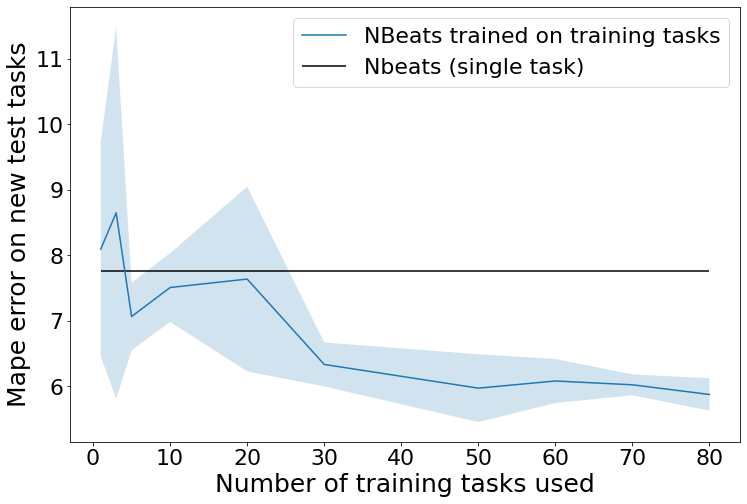

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(np.linspace(1,len(test_e), len(test_e)), test_e)
plt.plot(n_tasks, avg, label = 'NBeats trained on training tasks')
plt.fill_between(n_tasks, avg - std, avg + std, alpha=0.2)
#plt.errorbar(n_tasks, avg,  yerr=std, label = 'NBeats error on test tasks')
#plt.hlines(err_ari, xmin = 1, xmax= 80, label = 'Arima (single task) error on test tasks')
plt.hlines(np.average(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4])), xmin = 1, xmax= 80, label = 'Nbeats (single task)')
plt.xlabel('Number of training tasks used', size = 25)
plt.ylabel('Mape error on new test tasks', size = 25)
plt.legend()
plt.show()

In [ ]:
avg

array([8.09662741, 8.65070589, 7.06621881, 7.50933241, 7.6383308 ,
       6.33434772, 5.97208236, 6.08174559, 6.02333499, 5.87594463])

#### Run n=2,3 H= 5

In [ ]:
train_index = np.linspace(21000,21079,80, dtype = np.int)
n_tasks = np.array([1,3,5,10,20,30,50,60,70,80])
test_index = np.linspace(21080,21086,7, dtype = np.int)
errors_1, err_ari, err_snbeats1 = metaLearner(data, data_te, 300, n_tasks, 5, train_index, test_index, '1', start_H = 2, end_H = 3, meta_size = 25, ari = True)
errors_2, err_ari, err_snbeats2 = metaLearner(data, data_te, 300, n_tasks, 5, train_index, test_index, '2', start_H = 2, end_H = 3, meta_size = 25, ari = True)
errors_3, err_ari, err_snbeats3 = metaLearner(data, data_te, 300, n_tasks, 5, train_index, test_index, '3', start_H = 2, end_H = 3, meta_size = 25, ari = True)
errors_4, err_ari, err_snbeats4 = metaLearner(data, data_te, 300, n_tasks, 5, train_index, test_index, '4', start_H = 2, end_H = 3, meta_size = 25, ari =True)

#### Results Regimen 

In [ ]:
final_errors = np.concatenate((errors_1,errors_2,errors_3,errors_4)).reshape(4,len(n_tasks))
avg = np.average(final_errors,axis = 0)
std = np.std(final_errors,axis=0)

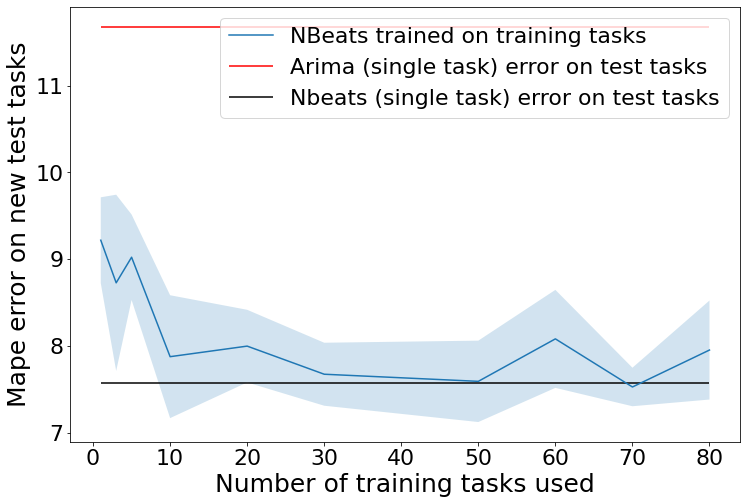

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(np.linspace(1,len(test_e), len(test_e)), test_e)
#plt.errorbar(n_tasks, avg,  yerr=std, label = 'NBeats error on test tasks')
plt.plot(n_tasks, avg, label = 'NBeats trained on training tasks')
plt.fill_between(n_tasks, avg - std, avg + std, alpha=0.2)
plt.hlines(11.68, xmin = 1, xmax= 80, colors = 'r', label = 'Arima (single task) error on test tasks')
avg_single = np.average(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4]))
std_single = np.std(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4]))
plt.hlines(avg_single, xmin = 1, xmax= 80, label = 'Nbeats (single task) error on test tasks')
#plt.fill_between(n_tasks, avg_single - std_single, avg_single + std_single, alpha=0.2)
plt.xlabel('Number of training tasks used', size = 25)
plt.ylabel('Mape error on new test tasks', size = 25)
plt.legend()
plt.show()

In [ ]:
avg

array([9.21771714, 8.72656777, 9.02168321, 7.87495529, 7.99677813,
       7.6725524 , 7.59056474, 8.08032075, 7.52551881, 7.95158605])

#### Run n=2 H=10

In [ ]:
train_index = np.linspace(21000,21079,80, dtype = np.int)
n_tasks = np.array([1,3,5,10,20,30,50,60,70,80])
test_index = np.linspace(21080,21086,7, dtype = np.int)
errors_1, err_ari, err_snbeats1 = metaLearner(data, data_te, 600, n_tasks, 10, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 40, ari = True)
errors_2, err_ari, err_snbeats2= metaLearner(data, data_te, 600, n_tasks, 10, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 40, ari = True)
errors_3, err_ari, err_snbeats3 = metaLearner(data, data_te, 600, n_tasks, 10, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 40, ari = True)
errors_4, err_ari, err_snbeats4 = metaLearner(data, data_te, 600, n_tasks, 10, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 40, ari = True)

#### Results Regimen 

In [ ]:
final_errors = np.concatenate((errors_1,errors_2,errors_3,errors_4)).reshape(4,len(n_tasks))
avg = np.average(final_errors,axis = 0)
std = np.std(final_errors,axis=0)

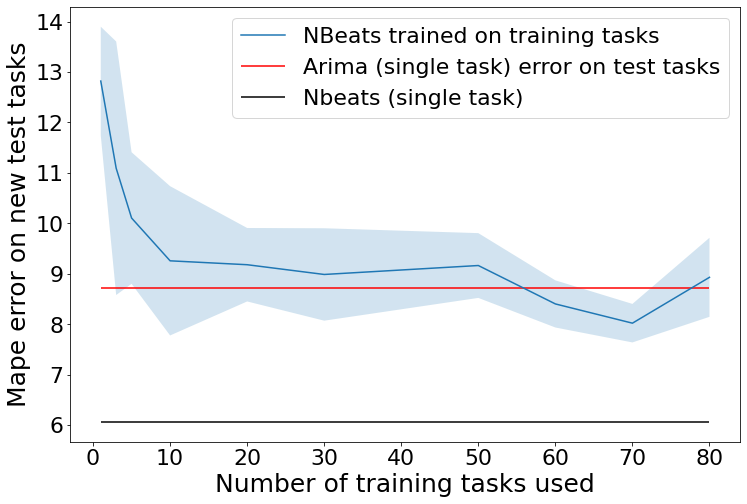

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(np.linspace(1,len(test_e), len(test_e)), test_e)
#plt.errorbar(n_tasks, avg,  yerr=std, label = 'NBeats error on test tasks')
plt.plot(n_tasks, avg, label = 'NBeats trained on training tasks')
plt.fill_between(n_tasks, avg - std, avg + std, alpha=0.2)
plt.hlines(err_ari, xmin = 1, xmax= 80, colors = 'r' , label = 'Arima (single task) error on test tasks')
plt.hlines(np.average(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4])), xmin = 1, xmax= 80, label = 'Nbeats (single task)')
plt.xlabel('Number of training tasks used', size = 25)
plt.ylabel('Mape error on new test tasks', size = 25)
plt.legend()
plt.show()

In [ ]:
avg

array([12.82067975, 11.09242308, 10.10548759,  9.2576565 ,  9.18042971,
        8.98720482,  9.16454728,  8.40328894,  8.02197185,  8.930811  ])

#### Run n=2,3 H=10

In [ ]:
train_index = np.linspace(21000,21079,80, dtype = np.int)
n_tasks = np.array([1,3,5,10,20,30,50,60,70,80])
test_index = np.linspace(21080,21086,7, dtype = np.int)
errors_1, err_ari, err_snbeats1= metaLearner(data, data_te, 500, n_tasks, 10, train_index, test_index, '1', start_H = 2, end_H = 3, meta_size = 50, ari = True)
errors_2, err_ari, err_snbeats2 = metaLearner(data, data_te, 500, n_tasks, 10, train_index, test_index, '1', start_H = 2, end_H = 3, meta_size = 50, ari = True)
errors_3, err_ari, err_snbeats3 = metaLearner(data, data_te, 500, n_tasks, 10, train_index, test_index, '1', start_H = 2, end_H = 3, meta_size = 50, ari = True)
errors_4, err_ari, err_snbeats4 = metaLearner(data, data_te, 500, n_tasks, 10, train_index, test_index, '1', start_H = 2, end_H = 3, meta_size = 50, ari = True)

#### Results Regimen 

In [ ]:
final_errors = np.concatenate((errors_1,errors_2,errors_3,errors_4)).reshape(4,len(n_tasks))
avg = np.average(final_errors,axis = 0)
std = np.std(final_errors,axis=0)

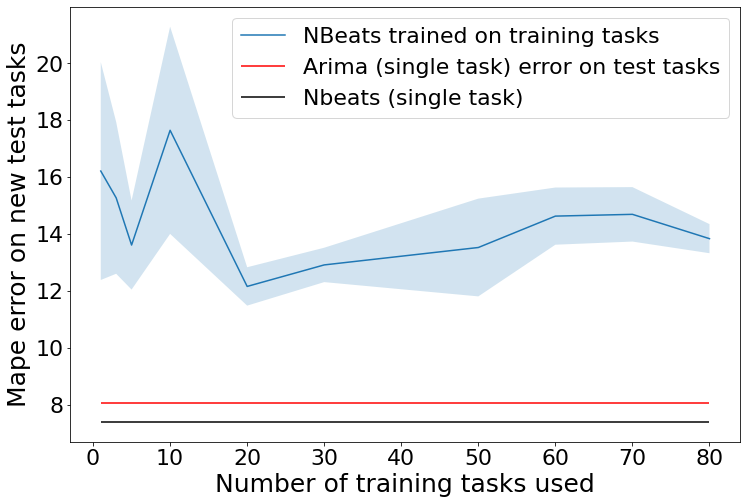

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(np.linspace(1,len(test_e), len(test_e)), test_e)
#plt.errorbar(n_tasks, avg,  yerr=std, label = 'NBeats error on test tasks')
plt.plot(n_tasks, avg, label = 'NBeats trained on training tasks')
plt.fill_between(n_tasks, avg - std, avg + std, alpha=0.2)
plt.hlines(err_ari, xmin = 1, xmax= 80, colors = 'r' , label = 'Arima (single task) error on test tasks')
plt.hlines(np.average(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4])), xmin = 1, xmax= 80, label = 'Nbeats (single task)')
plt.xlabel('Number of training tasks used', size = 25)
plt.ylabel('Mape error on new test tasks', size = 25)
plt.legend()
plt.show()

In [ ]:
avg

array([16.21325127, 15.26970979, 13.6113834 , 17.64585294, 12.1562606 ,
       12.91288656, 13.52499971, 14.62860756, 14.6910043 , 13.83573702])

#### Run n=2 H=18


In [ ]:
train_index = np.linspace(21000,21079,80, dtype = np.int)
n_tasks = np.array([1,3,5,10,20,30,50,60,70,80])
test_index = np.linspace(21080,21086,7, dtype = np.int)
errors_1, err_ari, err_snbeats1 = metaLearner(data, data_te, 300, n_tasks, 18, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 72, ari = True)
errors_2, err_ari, err_snbeats2= metaLearner(data, data_te, 300, n_tasks, 18, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 72, ari = True)
errors_3, err_ari, err_snbeats3 = metaLearner(data, data_te, 300, n_tasks, 18, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 72, ari = True)
errors_4, err_ari, err_snbeats4 = metaLearner(data, data_te, 300, n_tasks, 18, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 72, ari = True)

#### Results Regimen 

In [ ]:
final_errors = np.concatenate((errors_1,errors_2,errors_3,errors_4)).reshape(4,len(n_tasks))
avg = np.average(final_errors,axis = 0)
std = np.std(final_errors,axis=0)

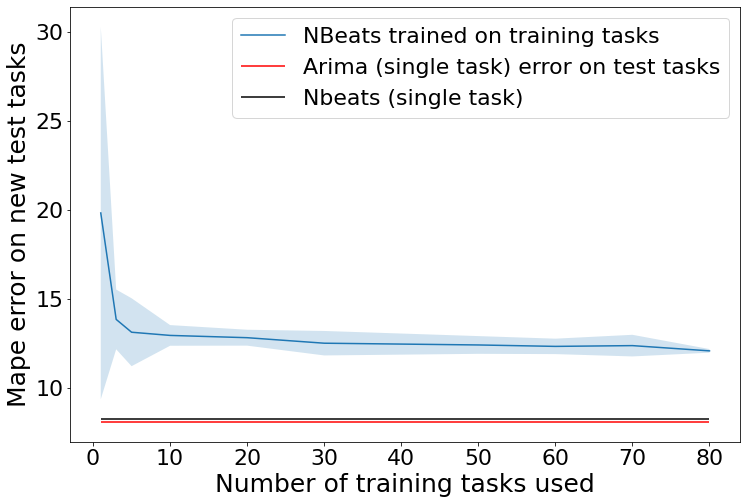

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(np.linspace(1,len(test_e), len(test_e)), test_e)
#plt.errorbar(n_tasks, avg,  yerr=std, label = 'NBeats error on test tasks')
plt.plot(n_tasks, avg, label = 'NBeats trained on training tasks')
plt.fill_between(n_tasks, avg - std, avg + std, alpha=0.2)
plt.hlines(err_ari, xmin = 1, xmax= 80, colors = 'r' , label = 'Arima (single task) error on test tasks')
plt.hlines(np.average(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4])), xmin = 1, xmax= 80, label = 'Nbeats (single task)')
plt.xlabel('Number of training tasks used', size = 25)
plt.ylabel('Mape error on new test tasks', size = 25)
plt.legend()
plt.show()

In [ ]:
avg

array([19.81300716, 13.83342543, 13.11284659, 12.93388226, 12.80582095,
       12.4959804 , 12.3974619 , 12.31759916, 12.36058772, 12.06577375])

#### Run n=2 H=3


In [ ]:
train_index = np.linspace(21000,21079,80, dtype = np.int)
n_tasks = np.array([1,3,5,10,20,30,50,60,70,80])
test_index = np.linspace(21080,21086,7, dtype = np.int)
errors_1, err_ari, err_snbeats1 = metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 12, ari = False)
errors_2, err_ari, err_snbeats2= metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 12, ari = False)
errors_3, err_ari, err_snbeats3 = metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 12, ari = False)
errors_4, err_ari, err_snbeats4 = metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 12, ari = False)

#### Results Regimen 

In [ ]:
final_errors = np.concatenate((errors_1,errors_2,errors_3,errors_4)).reshape(4,len(n_tasks))
avg = np.average(final_errors,axis = 0)
std = np.std(final_errors,axis=0)

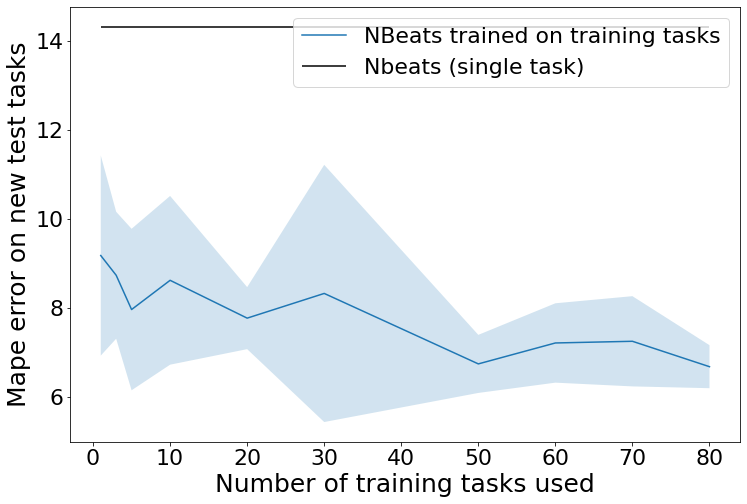

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(np.linspace(1,len(test_e), len(test_e)), test_e)
#plt.errorbar(n_tasks, avg,  yerr=std, label = 'NBeats error on test tasks')
plt.plot(n_tasks, avg, label = 'NBeats trained on training tasks')
plt.fill_between(n_tasks, avg - std, avg + std, alpha=0.2)
#plt.hlines(err_ari, xmin = 1, xmax= 80, colors = 'r' , label = 'Arima (single task) error on test tasks')
plt.hlines(np.average(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4])), xmin = 1, xmax= 80, label = 'Nbeats (single task)')
plt.xlabel('Number of training tasks used', size = 25)
plt.ylabel('Mape error on new test tasks', size = 25)
plt.legend()
plt.show()

In [ ]:
avg

array([9.17682043, 8.73308655, 7.96213657, 8.61943004, 7.76869871,
       8.32420888, 6.73938755, 7.21016283, 7.24799043, 6.67655122])

#### Run n=2,3 H=3


In [ ]:
train_index = np.linspace(21000,21079,80, dtype = np.int)
n_tasks = np.array([1,3,5,10,20,30,50,60,70,80])
test_index = np.linspace(21080,21086,7, dtype = np.int)
errors_1, err_ari, err_snbeats1 = metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '1', start_H = 2, end_H = 3, meta_size = 15, ari = False)
errors_2, err_ari, err_snbeats2= metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '2', start_H = 2, end_H = 3, meta_size = 15, ari = False)
errors_3, err_ari, err_snbeats3 = metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '3', start_H = 2, end_H = 3, meta_size = 15, ari = False)
errors_4, err_ari, err_snbeats4 = metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '4', start_H = 2, end_H = 3, meta_size = 15, ari = False)

#### Results Regimen 

In [ ]:
final_errors = np.concatenate((errors_1,errors_2,errors_3,errors_4)).reshape(4,len(n_tasks))
avg = np.average(final_errors,axis = 0)
std = np.std(final_errors,axis=0)

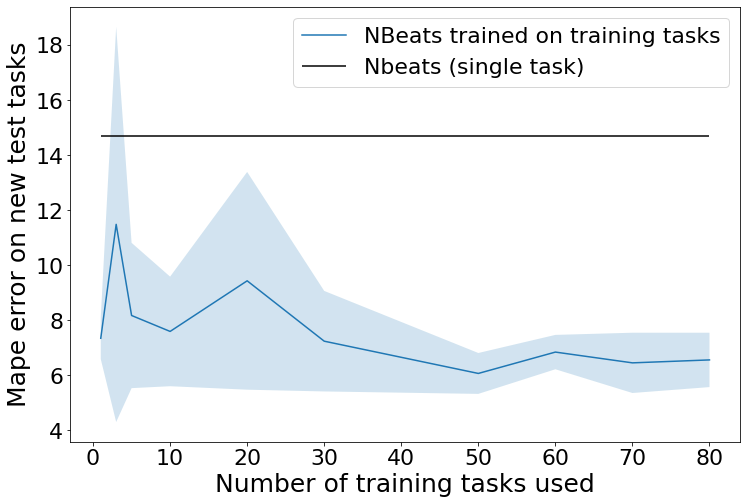

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(np.linspace(1,len(test_e), len(test_e)), test_e)
#plt.errorbar(n_tasks, avg,  yerr=std, label = 'NBeats error on test tasks')
plt.plot(n_tasks, avg, label = 'NBeats trained on training tasks')
plt.fill_between(n_tasks, avg - std, avg + std, alpha=0.2)
#plt.hlines(err_ari, xmin = 1, xmax= 80, colors = 'r' , label = 'Arima (single task) error on test tasks')
plt.hlines(np.average(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4])), xmin = 1, xmax= 80, label = 'Nbeats (single task)')
plt.xlabel('Number of training tasks used', size = 25)
plt.ylabel('Mape error on new test tasks', size = 25)
plt.legend()
plt.show()

In [ ]:
avg

array([ 7.3476382 , 11.48802918,  8.17548432,  7.59597633,  9.4359252 ,
        7.24134703,  6.06878258,  6.84525115,  6.45356519,  6.56049789])

#### Run n=2,3,4,5 H=3


In [ ]:
train_index = np.linspace(21000,21079,80, dtype = np.int)
n_tasks = np.array([1,3,5,10,20,30,50,60,70,80])
test_index = np.linspace(21080,21086,7, dtype = np.int)
errors_1, err_ari, err_snbeats1 = metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '1', start_H = 2, end_H = 5, meta_size = 21, ari = False)
errors_2, err_ari, err_snbeats2= metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '1', start_H = 2, end_H = 5, meta_size = 21, ari = False)
errors_3, err_ari, err_snbeats3 = metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '1', start_H = 2, end_H = 5, meta_size = 21, ari = False)
errors_4, err_ari, err_snbeats4 = metaLearner(data, data_te, 300, n_tasks, 3, train_index, test_index, '1', start_H = 2, end_H = 5, meta_size = 21, ari = False)

#### Results Regimen 

In [ ]:
final_errors = np.concatenate((errors_1,errors_2,errors_3,errors_4)).reshape(4,len(n_tasks))
avg = np.average(final_errors,axis = 0)
std = np.std(final_errors,axis=0)

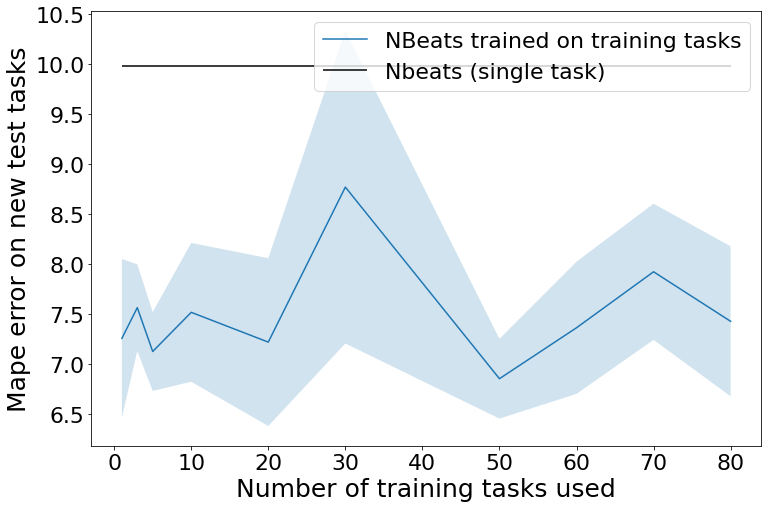

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(np.linspace(1,len(test_e), len(test_e)), test_e)
#plt.errorbar(n_tasks, avg,  yerr=std, label = 'NBeats error on test tasks')
plt.plot(n_tasks, avg, label = 'NBeats trained on training tasks')
plt.fill_between(n_tasks, avg - std, avg + std, alpha=0.2)
#plt.hlines(err_ari, xmin = 1, xmax= 80, colors = 'r' , label = 'Arima (single task) error on test tasks')
plt.hlines(np.average(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4])), xmin = 1, xmax= 80, label = 'Nbeats (single task)')
plt.xlabel('Number of training tasks used', size = 25)
plt.ylabel('Mape error on new test tasks', size = 25)
plt.legend()
plt.show()

In [ ]:
avg

array([7.25597484, 7.56334638, 7.12444551, 7.51650847, 7.21846435,
       8.7701462 , 6.85203932, 7.36187092, 7.9225025 , 7.42657296])

#### Run n=2 H=18 with more training for multi task


In [ ]:
train_index = np.linspace(21000,21079,80, dtype = np.int)
n_tasks = np.array([1,3,5,10,20,30,50,60,70,80])
test_index = np.linspace(21080,21086,7, dtype = np.int)
errors_1, err_ari, err_snbeats1 = metaLearner(data, data_te, 300, n_tasks, 18, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 72, ari = True)
errors_2, err_ari, err_snbeats2= metaLearner(data, data_te, 300, n_tasks, 18, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 72, ari = True)
errors_3, err_ari, err_snbeats3 = metaLearner(data, data_te, 300, n_tasks, 18, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 72, ari = True)
errors_4, err_ari, err_snbeats4 = metaLearner(data, data_te, 300, n_tasks, 18, train_index, test_index, '1', start_H = 2, end_H = 2, meta_size = 72, ari = True)

#### Results Regimen 

In [ ]:
final_errors = np.concatenate((errors_1,errors_2,errors_3,errors_4)).reshape(4,len(n_tasks))
avg = np.average(final_errors,axis = 0)
std = np.std(final_errors,axis=0)

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(np.linspace(1,len(test_e), len(test_e)), test_e)
#plt.errorbar(n_tasks, avg,  yerr=std, label = 'NBeats error on test tasks')
plt.plot(n_tasks, avg, label = 'NBeats trained on training tasks')
plt.fill_between(n_tasks, avg - std, avg + std, alpha=0.2)
plt.hlines(err_ari, xmin = 1, xmax= 80, colors = 'r' , label = 'Arima (single task) error on test tasks')
plt.hlines(np.average(np.array([err_snbeats1,err_snbeats2,err_snbeats3,err_snbeats4])), xmin = 1, xmax= 80, label = 'Nbeats (single task)')
plt.xlabel('Number of training tasks used', size = 25)
plt.ylabel('Mape error on new test tasks', size = 25)
plt.legend()
plt.show()

In [ ]:
avg

array([20.99347726, 14.17708961, 12.37718279, 12.43599093, 13.53591932,
       11.86307622, 12.45837214, 12.25262742, 12.09942614, 12.39442576])

## Experiments for effects of different components

Here we test how ensembling affects performance, and we also analyze the hyperparameter tuning for the NBeats architecture in the single task setting

### Tests for past horizon effect 

In [ ]:
def testPastHorizon(data, horizon_val, forecast_l, loss, n_epochs, v):

  test_e = []
  
  for n in horizon_val:

    print('TEST FOR N = ' , ' {0} '.format(n) )

    x_train,x_test,y_train,y_test,x_tr,x_te = makeTS(data,forecast_l, n*forecast_l)

    
    net = NBeatsNet(device=device, 
                  stack_types=('generic','generic'),
                  thetas_dims=(20,40), 
                  forecast_length=forecast_l, 
                  backcast_length=n*forecast_l,
                  hidden_layer_units=512, 
                  share_weights_in_stack=False,
                  nb_blocks_per_stack=15
                  )
    
    print('Parameter count is:', sum(p.numel() for p in net.parameters() if p.requires_grad))
    
    train_data = []
    for i in range(len(x_train)):
      train_data.append((x_train[i],y_train[i]))

    test_data = []
    for i in range(len(x_test)):
      test_data.append((x_test[i],y_test[i])) 
    
    idmod = '/Behavior_tests/' + 'electric_' + '{0}'.format(n) + 'H_' + loss + v

    
    tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=0.0003, weight_dec = 0, loss_f = loss  , idmod = idmod)

    p = makeparray(net,test_data,forecast_l)
    err = getAvgError(p[forecast_l:],test_data[forecast_l:],loss) 
    test_e.append(err)
    print('The average ' + loss + ' error ' + ' is: ', err)

    np.savetxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions', p)
  
  #Testing ensemble:

  x_train,x_test,y_train,y_test,x_tr,x_te = makeTS(data,forecast_l,horizon_val[-1]*forecast_l)

  train_data = []
  for i in range(len(x_train)):
    train_data.append((x_train[i],y_train[i]))

  test_data = []
  for i in range(len(x_test)):
    test_data.append((x_test[i],y_test[i]))


  i = 0 
  T = horizon_val[-1]

  for n in horizon_val:
    if i==0:
      idmod = '/Behavior_tests/' +'electric_' + '{0}'.format(n) + 'H_' + loss + v
      p = (np.loadtxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions'))/T

    else:
      idmod = '/Behavior_tests/' +'electric_' + '{0}'.format(n) + 'H_' + loss + v
      temp = np.loadtxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions')
      if (p.shape)!=(temp.shape):
        p = p[p.shape[0]-temp.shape[0]:] + temp/T
      else:
        p = p + temp/T

    i+=1

  ensemble_err = getAvgError(p[forecast_l:], test_data[forecast_l:], loss) 


  return test_e,ensemble_err

#### H=5, MAPE

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/electric.csv', index_col = 0)

H=5
horizon_val = np.array([1,2,3,4,5,6,7,8,9,10])
errors,en = testPastHorizon(data, horizon_val, H, 'mape', 1000, '1')
errors_2,en2 = testPastHorizon(data, horizon_val, H, 'mape', 1000, '2')
errors_3,en3 = testPastHorizon(data, horizon_val, H, 'mape', 1000, '3')
final_errors = np.concatenate((errors,errors_2,errors_3)).reshape(3,len(horizon_val))

In [ ]:
final_errors = np.concatenate((errors,errors_2,errors_3)).reshape(3,len(horizon_val))

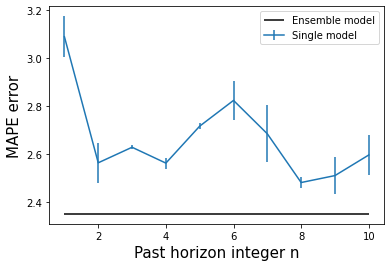

In [ ]:
plt.errorbar(horizon_val, np.average(final_errors,axis=0), yerr=np.std(final_errors,axis=0),label='Single model')
plt.hlines(np.average([en,en2,en3]), xmin=1, xmax=10,label='Ensemble model')
plt.xlabel('Past horizon integer n',size=15)
plt.ylabel('MAPE error',size=15)
plt.legend()
plt.show()

Testing ensembling of all the trained networks to see effect on final performance

#### H=5, sMAPE

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/electric.csv', index_col = 0)

H=5
horizon_val = np.array([1,2,3,4,5,6,7,8,9,10])
errors,en = testPastHorizon(data, horizon_val, H, 'smape', 1000, '1')
errors_2,en2 = testPastHorizon(data, horizon_val, H, 'smape', 1000, '2')
errors_3,en3 = testPastHorizon(data, horizon_val, H, 'smape', 1000, '3')
final_errors = np.concatenate((errors,errors_2,errors_3)).reshape(3,len(horizon_val))

In [ ]:
final_errors = np.concatenate((errors,errors_2,errors_3)).reshape(3,len(horizon_val))

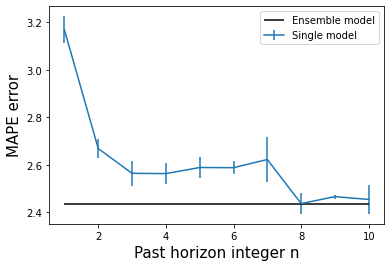

In [ ]:
plt.errorbar(horizon_val, np.average(final_errors,axis=0), yerr=np.std(final_errors,axis=0),label='Single model')
plt.hlines(np.average([en,en2,en3]), xmin=1, xmax=10,label='Ensemble model')
plt.xlabel('Past horizon integer n',size=15)
plt.ylabel('MAPE error',size=15)
plt.legend()
plt.show()

Testing ensembling of all the trained networks to see effect on final performance

### Tests for progressive past horizon effect 

In [ ]:
def testPastHorizonP(data, horizon_val, forecast_l, loss, n_epochs, v):

  l = 0
  test_e = []
  T = len(horizon_val)
  
  for n in horizon_val:

    print('TEST FOR N = ' , ' {0} '.format(n) )

    x_train,x_test,y_train,y_test,x_tr,x_te = makeTS(data,forecast_l, n*forecast_l)

    net = NBeatsNet(device=device, 
                  stack_types=('generic','generic'),
                  thetas_dims=(20,40), 
                  forecast_length=forecast_l, 
                  backcast_length=n*forecast_l,
                  hidden_layer_units=512, 
                  share_weights_in_stack=False,
                  nb_blocks_per_stack=15
                  )
    
    print('Parameter count is:', sum(p.numel() for p in net.parameters() if p.requires_grad))
    
    train_data = []
    for i in range(len(x_train)):
      train_data.append((x_train[i],y_train[i]))

    test_data = []
    for i in range(len(x_test)):
      test_data.append((x_test[i],y_test[i])) 
    
    idmod = '/Behavior_tests/' + 'electric_prog' + '{0}'.format(n) + 'H_' + loss + v

    tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=0.0003, weight_dec = 0, loss_f = loss  , idmod = idmod)

    temp = makeparray(net, test_data, forecast_l)

    if (l == 0):
          p = temp/1

    else:
        if (p.shape)!=(temp.shape):
          p = p[p.shape[0]-temp.shape[0]:]*(1 - (1/(l+1))) + temp/(l+1)
        else:
          p = p*(1 - (1/l+1)) + temp/(l+1)

    l+=1

    err = getAvgError(p[forecast_l:],test_data[forecast_l:],loss)
    test_e.append(err)
    
    print('The average ' + loss + ' error ' + ' is: ', err)

  return test_e

#### H=5, MAPE

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/electric.csv', index_col = 0)

H=5
horizon_val = np.array([1,2,3,4,5,6,7,8,9,10])
errors= testPastHorizonP(data, horizon_val, H, 'mape', 500, '1')
errors_2 = testPastHorizonP(data, horizon_val, H, 'mape', 500, '2')
errors_3 = testPastHorizonP(data, horizon_val, H, 'mape', 500, '3')
errors_4= testPastHorizonP(data, horizon_val, H, 'mape', 500, '4')
errors_5 = testPastHorizonP(data, horizon_val, H, 'mape', 500, '5')
errors_6 = testPastHorizonP(data, horizon_val, H, 'mape', 500, '6')
final_errors = np.concatenate((errors,errors_2,errors_3,errors_4,errors_5,errors_6)).reshape(6,len(horizon_val))

In [ ]:
plt.rcParams.update({'font.size': 22})

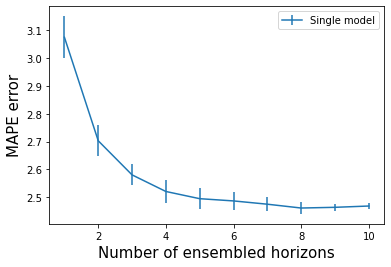

In [ ]:
plt.errorbar(horizon_val, np.average(final_errors,axis=0), yerr=np.std(final_errors,axis=0),label='Single model')
#plt.hlines(np.average([en,en2,en3]), xmin=1, xmax=10,label='Ensemble model')
plt.xlabel('Number of ensembled horizons',size=15)
plt.ylabel('MAPE error',size=15)
plt.legend()
plt.show()

Testing ensembling of all the trained networks to see effect on final performance

#### H=5, sMAPE

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dissertation/Data/electric.csv', index_col = 0)

H=5
horizon_val = np.array([1,2,3,4,5,6,7,8,9,10])
errors= testPastHorizonP(data, horizon_val, H, 'smape', 500, '1')
errors_2 = testPastHorizonP(data, horizon_val, H, 'smape', 500, '2')
errors_3 = testPastHorizonP(data, horizon_val, H, 'smape', 500, '3')
errors_4= testPastHorizonP(data, horizon_val, H, 'smape', 500, '4')
errors_5 = testPastHorizonP(data, horizon_val, H, 'smape', 500, '5')
errors_6 = testPastHorizonP(data, horizon_val, H, 'smape', 500, '6')
final_errors = np.concatenate((errors,errors_2,errors_3,errors_4,errors_5,errors_6)).reshape(6,len(horizon_val))

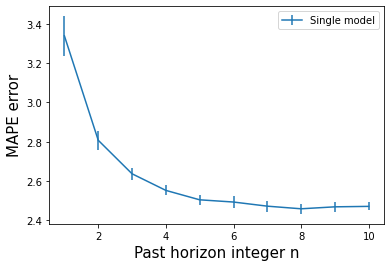

In [ ]:
plt.errorbar(horizon_val, np.average(final_errors,axis=0), yerr=np.std(final_errors,axis=0),label='Single model')
#plt.hlines(np.average([en,en2,en3]), xmin=1, xmax=10,label='Ensemble model')
plt.xlabel('Past horizon integer n',size=15)
plt.ylabel('MAPE error',size=15)
plt.legend()
plt.show()

Testing ensembling of all the trained networks to see effect on final performance

### Tests for depths and breadth effects (unit size, number of blocks)

Depth

In [ ]:
def testDepthEffect(block_val, forecast_l, loss, n_epochs, sw):

  test_e = []
  params = []
  
  for n in block_val:

    print('TEST FOR N = ' , ' {0} '.format(n) )

    x_train,x_test,y_train,y_test = makeMilk(forecast_l, 4*forecast_l)

    
    net = NBeatsNet(device=device, 
                  stack_types=('generic','generic'),
                  thetas_dims=(4,8), 
                  forecast_length=forecast_l, 
                  backcast_length=4*forecast_l,
                  hidden_layer_units=256, 
                  share_weights_in_stack=sw,
                  nb_blocks_per_stack=n
                  )
    
    param =  sum(p.numel() for p in net.parameters() if p.requires_grad)
    
    print('Parameter count is:', param)

    params.append(param)
    
    train_data = []
    for i in range(len(x_train)):
      train_data.append((x_train[i],y_train[i]))

    test_data = []
    for i in range(len(x_test)):
      test_data.append((x_test[i],y_test[i])) 
    
    idmod = 'milk_' + '{0}'.format(n) + '_4H_' + loss 
    tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=0.001, weight_dec = 0.0001, loss_f = loss  , idmod = idmod)

    p = makeparray(net,test_data,forecast_l)
    err = getAvgError(p[forecast_l:],test_data[forecast_l:],loss) 
    test_e.append(err)
    print('The average ' + loss + ' error ' + ' is: ', err)

    np.savetxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions', p)
  
  #Testing ensemble:

  x_train,x_test,y_train,y_test = makeMilk(forecast_l,4*forecast_l)

  train_data = []
  for i in range(len(x_train)):
    train_data.append((x_train[i],y_train[i]))

  test_data = []
  for i in range(len(x_test)):
    test_data.append((x_test[i],y_test[i]))


  i = 0 
  T = block_val[-1]

  for n in block_val:
    if i==0:
      idmod = 'milk_' + '{0}'.format(n) + '_4H_' + loss 
      p = (np.loadtxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions'))/T

    else:
      idmod = 'milk_' + '{0}'.format(n) + '_4H_' + loss
      temp = np.loadtxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions')
      if (p.shape)!=(temp.shape):
        p = p[p.shape[0]-temp.shape[0]:] + temp/T
      else:
        p = p + temp/T

    i+=1

  ensemble_err = getAvgError(p, test_data, loss) 


  return test_e,ensemble_err,params

In [ ]:
H=3
block_val = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
errors,en,params = testDepthEffect(block_val, H, 'mape', 1000, False)
errors_2,en2,params = testDepthEffect(block_val, H, 'mape', 1000, False)
errors_3,en3,params = testDepthEffect(block_val, H, 'mape', 1000, False)
final_errors = np.concatenate((errors,errors_2,errors_3)).reshape(3,len(block_val))

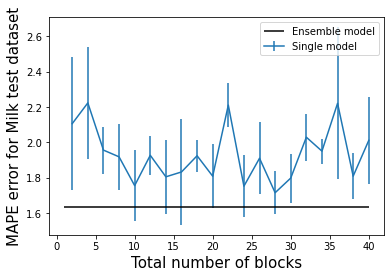

In [ ]:
plt.errorbar(2*block_val, np.average(final_errors,axis=0), yerr=np.std(final_errors,axis=0),label='Single model')
plt.hlines(np.average([en,en2,en3]), xmin=1, xmax=40,label='Ensemble model')
plt.xlabel('Total number of blocks',size=15)
plt.ylabel('MAPE error for Milk test dataset',size=15)
plt.legend()
plt.show()

Breadth

In [ ]:
def testBreadthEffect(breadth_val, forecast_l, loss, n_epochs, sw):

  test_e = []
  params = []
  
  for n in breadth_val:

    print('TEST FOR N = ' , ' {0} '.format(n) )

    x_train,x_test,y_train,y_test = makeMilk(forecast_l, 4*forecast_l)

    
    net = NBeatsNet(device=device, 
                  stack_types=('generic','generic'),
                  thetas_dims=(4,8), 
                  forecast_length=forecast_l, 
                  backcast_length=4*forecast_l,
                  hidden_layer_units=32*n, 
                  share_weights_in_stack=sw,
                  nb_blocks_per_stack=5
                  )
    
    param =  sum(p.numel() for p in net.parameters() if p.requires_grad)
    
    print('Parameter count is:', param)

    params.append(param)
    
    train_data = []
    for i in range(len(x_train)):
      train_data.append((x_train[i],y_train[i]))

    test_data = []
    for i in range(len(x_test)):
      test_data.append((x_test[i],y_test[i])) 
    
    idmod = 'milk_' + '{0}'.format(n) + '_4H_' + loss 
    tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=0.001, weight_dec = 0.0001, loss_f = loss  , idmod = idmod)

    p = makeparray(net,test_data,forecast_l)
    err = getAvgError(p[forecast_l:],test_data[forecast_l:],loss) 
    test_e.append(err)
    print('The average ' + loss + ' error ' + ' is: ', err)

    np.savetxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions', p)
  
  #Testing ensemble:

  x_train,x_test,y_train,y_test = makeMilk(forecast_l,4*forecast_l)

  train_data = []
  for i in range(len(x_train)):
    train_data.append((x_train[i],y_train[i]))

  test_data = []
  for i in range(len(x_test)):
    test_data.append((x_test[i],y_test[i]))


  i = 0 
  T = breadth_val[-1]

  for n in breadth_val:
    if i==0:
      idmod = 'milk_' + '{0}'.format(n) + '_4H_' + loss 
      p = (np.loadtxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions'))/T

    else:
      idmod = 'milk_' + '{0}'.format(n) + '_4H_' + loss
      temp = np.loadtxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions')
      if (p.shape)!=(temp.shape):
        p = p[p.shape[0]-temp.shape[0]:] + temp/T
      else:
        p = p + temp/T

    i+=1

  ensemble_err = getAvgError(p[forecast_l:], test_data[forecast_l:], loss) 


  return test_e,ensemble_err,params

In [ ]:
H=3
breadth_val = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
errors,en,params = testBreadthEffect(breadth_val, H, 'mape', 1000, False)
errors_2,en2,params = testBreadthEffect(breadth_val, H, 'mape', 1000, False)
errors_3,en3,params = testBreadthEffect(breadth_val, H, 'mape', 1000, False)
final_errors = np.concatenate((errors,errors_2,errors_3)).reshape(3,len(block_val))

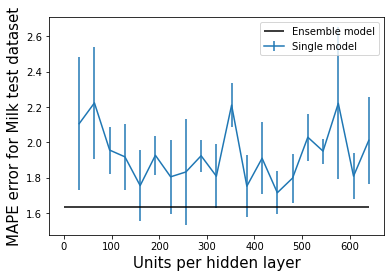

In [ ]:
plt.errorbar(32*breadth_val, np.average(final_errors,axis=0), yerr=np.std(final_errors,axis=0),label='Single model')
plt.hlines(np.average([en,en2,en3]), xmin=1, xmax=20*32,label='Ensemble model')
plt.xlabel('Units per hidden layer',size=15)
plt.ylabel('MAPE error for Milk test dataset',size=15)
plt.legend()
plt.show()

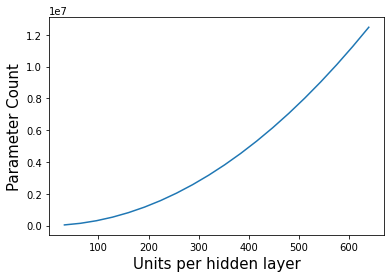

In [ ]:
plt.plot(32*block_val, params)
plt.xlabel('Units per hidden layer',size=15)
plt.ylabel('Parameter Count',size=15)
plt.show()

### Test for Thetas dimension effects

In [ ]:
def testThetasEffect(theta_val, forecast_l, loss, n_epochs, sw):

  test_e = []
  params = []
  
  for n in theta_val:

    print('TEST FOR N = ' , ' {0} '.format(n) )

    x_train,x_test,y_train,y_test = makeMilk(forecast_l, 4*forecast_l)

    
    net = NBeatsNet(device=device, 
                  stack_types=('generic','generic'),
                  thetas_dims=(4*n,8*n), 
                  forecast_length=forecast_l, 
                  backcast_length=4*forecast_l,
                  hidden_layer_units=256, 
                  share_weights_in_stack=sw,
                  nb_blocks_per_stack=5
                  )
    
    param =  sum(p.numel() for p in net.parameters() if p.requires_grad)
    
    print('Parameter count is:', param)

    params.append(param)
    
    train_data = []
    for i in range(len(x_train)):
      train_data.append((x_train[i],y_train[i]))

    test_data = []
    for i in range(len(x_test)):
      test_data.append((x_test[i],y_test[i])) 
    
    idmod = 'milk_' + '{0}'.format(n) + '_4H_' + loss 
    tr,val = train(net, train_data, batch_size=128, n_epochs = n_epochs, learning_rate=0.001, weight_dec = 0.0001, loss_f = loss  , idmod = idmod)

    p = makeparray(net,test_data,forecast_l)
    err = getAvgError(p[forecast_l:],test_data[forecast_l:],loss) 
    test_e.append(err)
    print('The average ' + loss + ' error ' + ' is: ', err)

    np.savetxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions', p)
  
  #Testing ensemble:

  x_train,x_test,y_train,y_test = makeMilk(forecast_l,4*forecast_l)

  train_data = []
  for i in range(len(x_train)):
    train_data.append((x_train[i],y_train[i]))

  test_data = []
  for i in range(len(x_test)):
    test_data.append((x_test[i],y_test[i]))


  i = 0 
  T = theta_val[-1]

  for n in theta_val:
    if i==0:
      idmod = 'milk_' + '{0}'.format(n) + '_4H_' + loss 
      p = (np.loadtxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions'))/T

    else:
      idmod = 'milk_' + '{0}'.format(n) + '_4H_' + loss
      temp = np.loadtxt('/content/drive/My Drive/Dissertation/Network' + idmod + '_predictions')
      if (p.shape)!=(temp.shape):
        p = p[p.shape[0]-temp.shape[0]:] + temp/T
      else:
        p = p + temp/T

    i+=1

  ensemble_err = getAvgError(p[forecast_l:], test_data[forecast_l:], loss) 


  return test_e,ensemble_err,params

In [ ]:
H=3
N = 1000
theta_val = np.array([1,2,3,4,5,6,7,8,9,10])
errors,en,params = testThetasEffect(theta_val, H, 'mape', N, False)
errors_2,en2,params = testThetasEffect(theta_val, H, 'mape', N, False)
errors_3,en3,params = testThetasEffect(theta_val, H, 'mape', N, False)
errors_4,en4,params = testThetasEffect(theta_val, H, 'mape', N, False)
errors_5,en5,params = testThetasEffect(theta_val, H, 'mape', N, False)
final_errors = np.concatenate((errors,errors_2,errors_3,errors_4,errors_5)).reshape(5,len(theta_val))

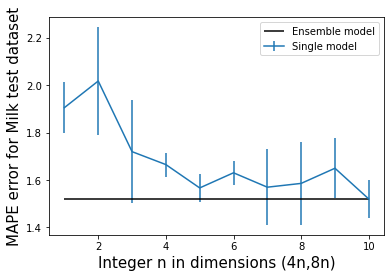

In [ ]:
plt.errorbar(theta_val, np.average(final_errors,axis=0), yerr=np.std(final_errors,axis=0),label='Single model')
plt.hlines(np.average([en,en2,en3,en4,en5]), xmin=1, xmax=10,label='Ensemble model')
plt.xlabel('Integer n in dimensions (4n,8n)',size=15)
plt.ylabel('MAPE error for Milk test dataset',size=15)
plt.legend()
plt.show()

## Test values

Here we test models trained in the single task setting. Each model trained for the ensembled part is tested on the test data here

In [ ]:
p = makeparray(net,test_data,forecast_length)
np.savetxt('/content/drive/My Drive/Dissertation/Network/' + idmod + '_predictions', p)
# to load p = np.loadtxt('/content/drive/My Drive/Dissertation/Network/' +idmod + '_predictions')

#### Milk

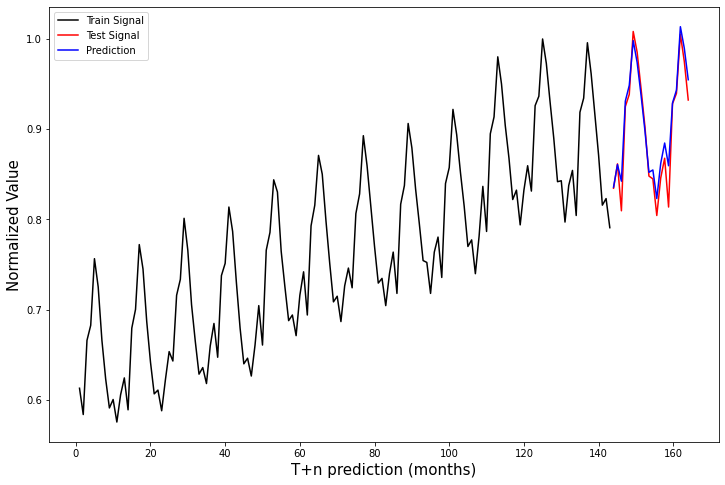

1.4424270268288748
1.458117721198142


In [ ]:
n = 5
y_pred = []
L = len(x_tr)
x = np.concatenate((x_tr,x_te))
n_steps = len(p)//n 

for i in range(n_steps): 
  y_pred.append(p[i*n])

y_pred = np.array(y_pred).flatten()[n:]
y = x[L+n:L+n_steps*n]

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L+n,L+n), x[:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('T+n prediction (months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

print(getAvgError(p[n:],test_data[n:],'smape'))
print(getAvgError(p[n:],test_data[n:],'mape'))

#### Milk-I

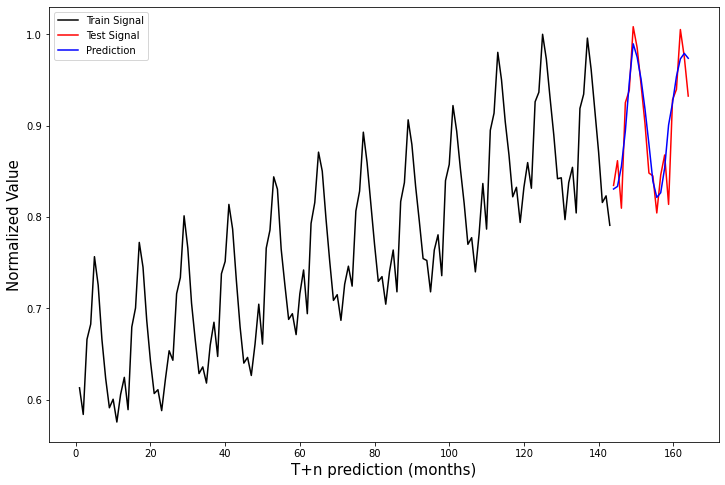

2.320128960150388
2.348455495251113


In [ ]:
n = 5
y_pred = []
L = len(x_tr)
x = np.concatenate((x_tr,x_te))
n_steps = len(p)//n 

for i in range(n_steps): 
  y_pred.append(p[i*n])

y_pred = np.array(y_pred).flatten()[n:]
y = x[L+n:L+n_steps*n]

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L+n,L+n), x[:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('T+n prediction (months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

print(getAvgError(p[n:],test_data[n:],'smape'))
print(getAvgError(p[n:],test_data[n:],'mape'))

#### Beer

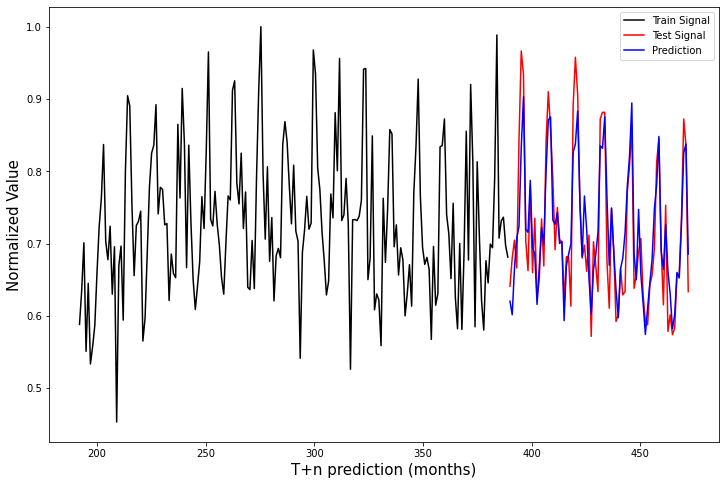

4.8708612496384465
4.9135138932166145


In [ ]:
n = 5
y_pred = []
L = len(x_tr)
x = np.concatenate((x_tr,x_te))
n_steps = len(p)//n 

for i in range(n_steps): 
  y_pred.append(p[i*n])

y_pred = np.array(y_pred).flatten()[n:]
y = x[L+n:L+n_steps*n]

plt.figure(figsize=(12,8))
plt.plot(np.linspace(L//2,L+n,L//2+n), x[L//2:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

print(getAvgError(p[n:],test_data[n:],'smape'))
print(getAvgError(p[n:],test_data[n:],'mape'))

#### Beer-I

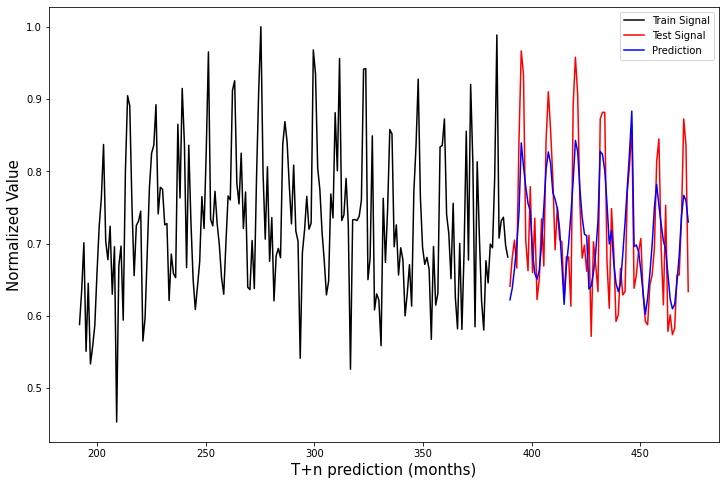

6.892794211486178
6.990631479901908


In [ ]:
n = 5
y_pred = []
L = len(x_tr)
x = np.concatenate((x_tr,x_te))
n_steps = len(p)//n 

for i in range(n_steps): 
  y_pred.append(p[i*n])

y_pred = np.array(y_pred).flatten()[n:]
y = x[L+n:L+n_steps*n]

plt.figure(figsize=(12,8))
plt.plot(np.linspace(L//2,L+n,L//2+n), x[L//2:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('T+n prediction (months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

print(getAvgError(p[n:],test_data[n:],'smape'))
print(getAvgError(p[n:],test_data[n:],'mape'))

#### Electric

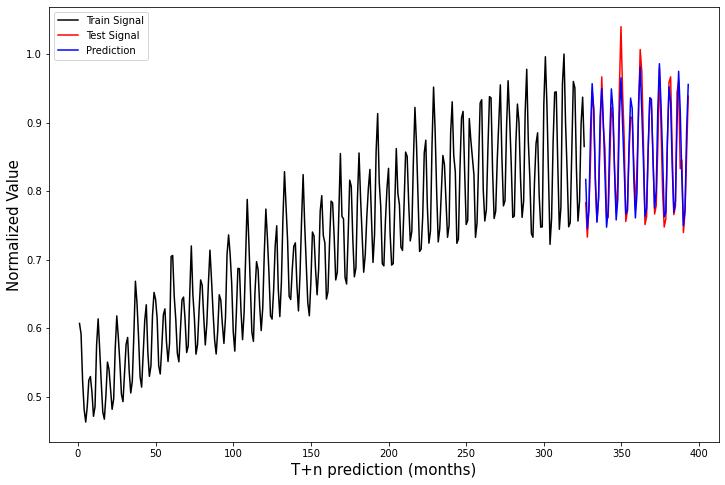

2.410761207552203
2.4122132531851537


In [ ]:
n = 5
y_pred = []
L = len(x_tr)
x = np.concatenate((x_tr,x_te))
n_steps = len(p)//n 

for i in range(n_steps): 
  y_pred.append(p[i*n])

y_pred = np.array(y_pred).flatten()[n:]
y = x[L+n:L+n_steps*n]

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L+n,L+n), x[:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

print(getAvgError(p[n:],test_data[n:],'smape'))
print(getAvgError(p[n:],test_data[n:],'mape'))

#### Electric-Single

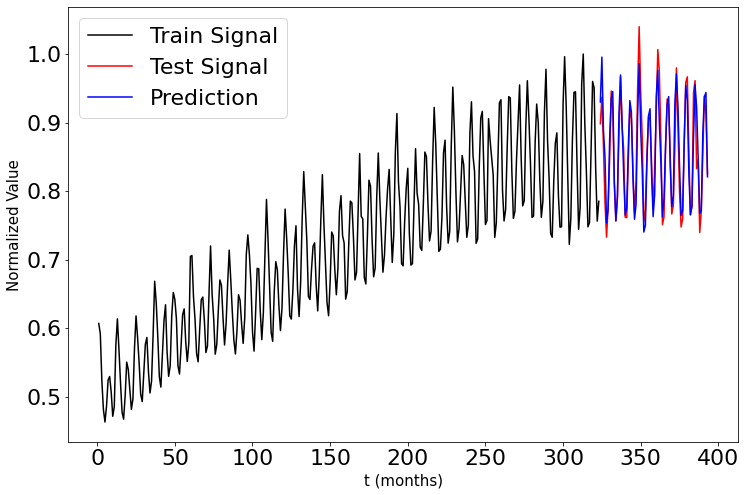

2.5235892483927205
2.5245966976905945


In [ ]:
n = 5
y_pred = []
L = len(x_tr)
x = np.concatenate((x_tr,x_te))
n_steps = len(p)//n 

for i in range(n_steps): 
  y_pred.append(p[i*n])

y_pred = np.array(y_pred).flatten()[n:]
y = x[L+n:L+n_steps*n]

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L+n,L+n), x[:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

print(getAvgError(p[n:],test_data[n:],'smape'))
print(getAvgError(p[n:],test_data[n:],'mape'))

#### M4-M21000

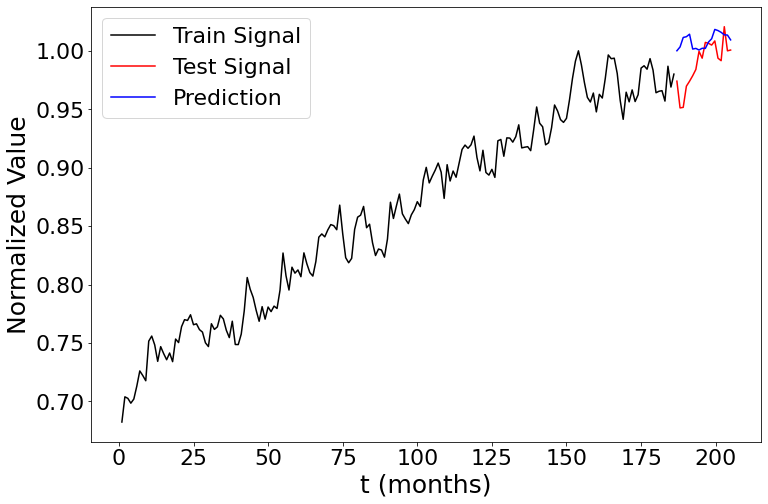

2.107747739406916
2.07050558998007


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

#### M4-M21001

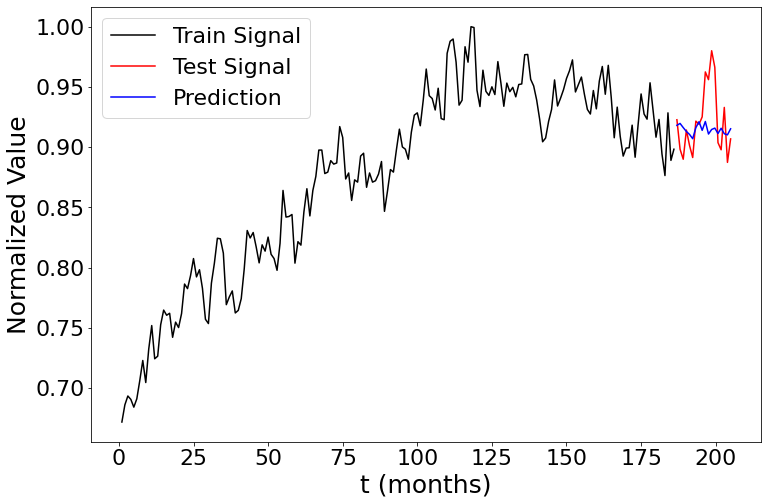

2.241349594921319
2.267147313722183


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

#### M4-M21002

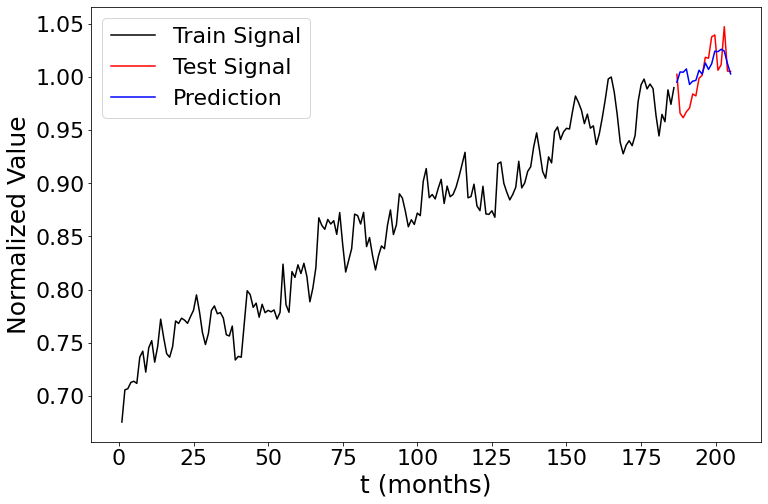

1.7223980238269134
1.7078908628473075


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

#### M4-M21003

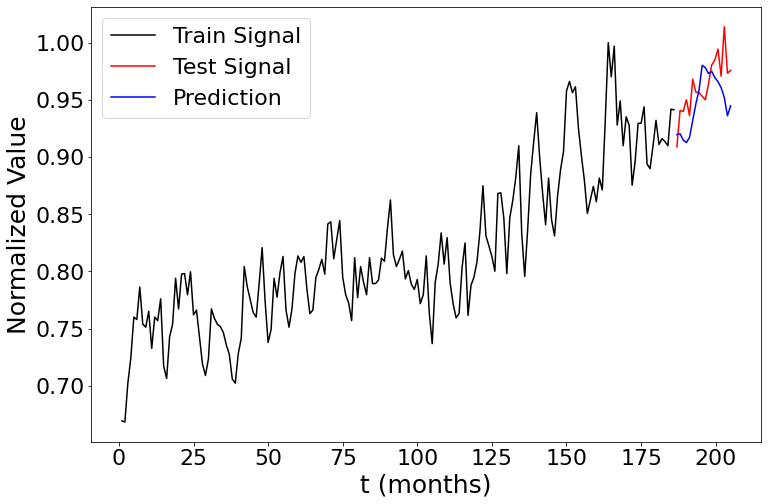

2.3802103571029987
2.409157263409553


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

#### M4-M21004

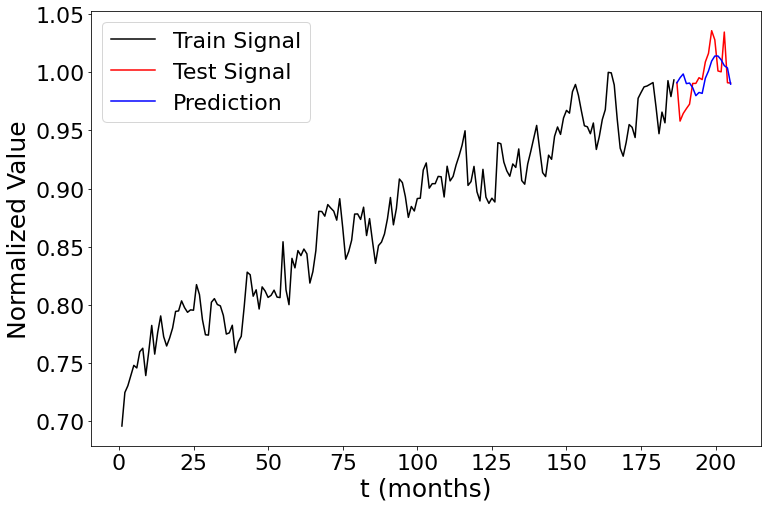

1.5927453800133078
1.5885652577223512


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

#### M4-M200

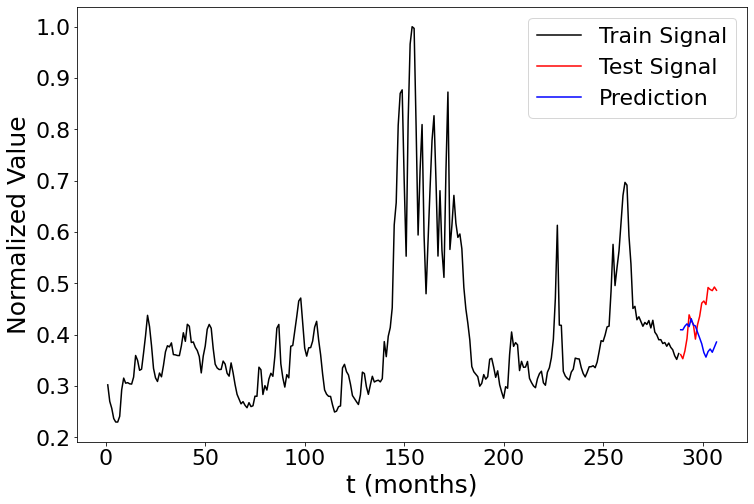

14.190857062166916
15.325024101439007


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

#### M4-M500

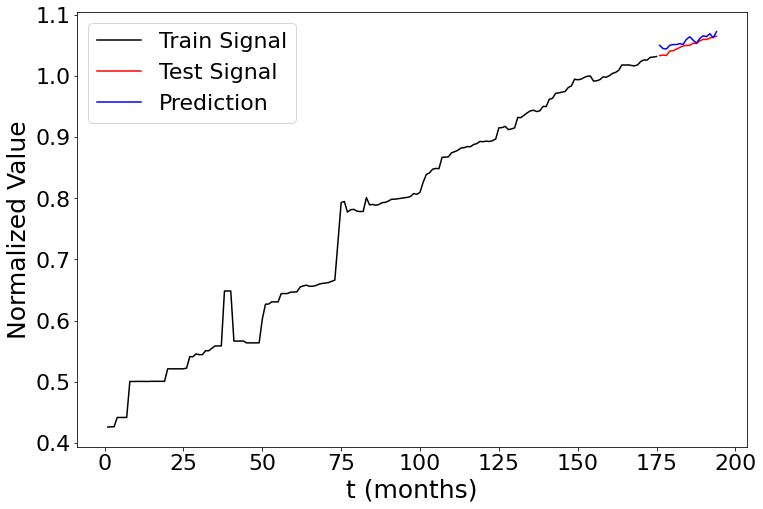

0.7119585231732953
0.7086597403491139


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()

plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

#### M4-M2000

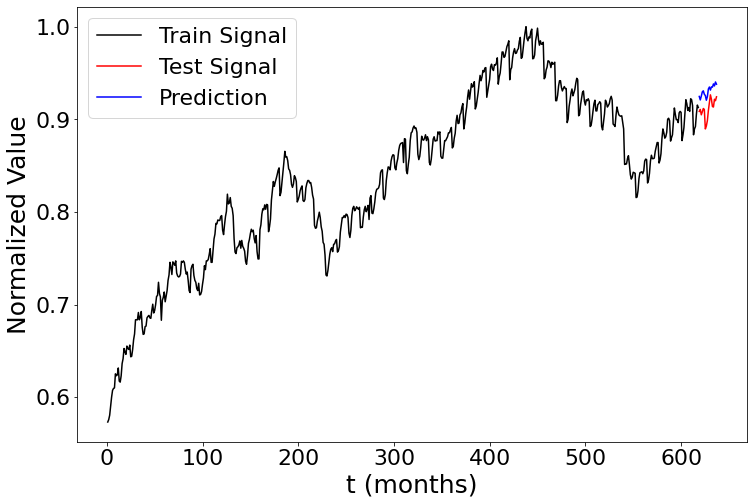

2.117148907592678
2.0920450293313717


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

#### M4-M4000

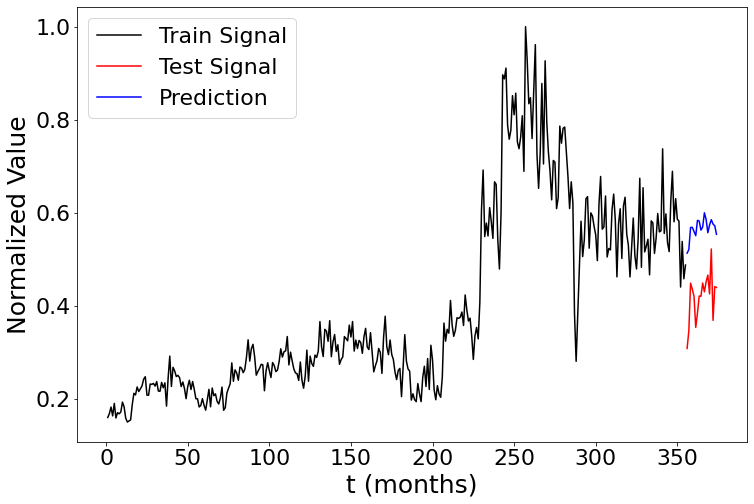

36.65873171541803
30.419542549708673


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

#### M4-M12000

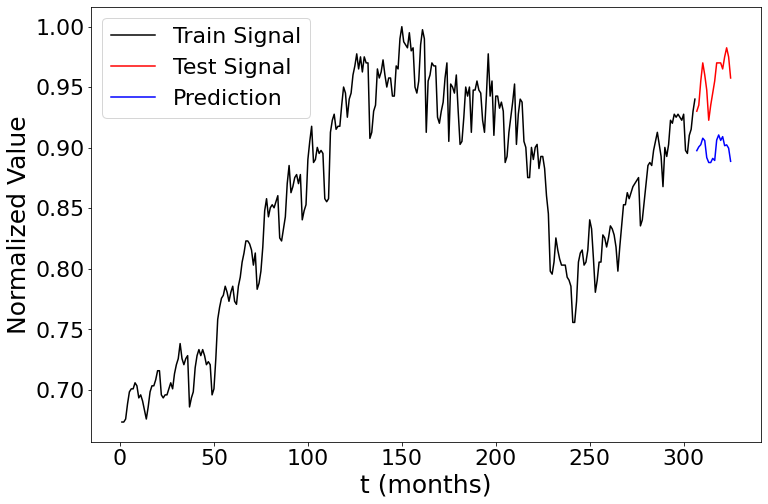

5.9898660324488775
6.184177242459806


In [ ]:
n = 18
y_pred = []
L = len(x_tr)

y_pred = np.array(p).flatten()
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

print(MAPE(y_pred,y_te))
print(sMAPE(y_pred,y_te))

## Baselines

Here we train the baselines in the single task setting. Each model trained for the ensembled part is compared to baselines here

### Seasonal Arima

#### Milk

In [ ]:
y_sarima = []
model = SARIMAX(x[:L], order=(5,1,0), seasonal_order = (2,1,0,12))
model_fit = model.fit(disp=0)
temp = model_fit.forecast(steps = n)
y_sarima.append(temp)

for i in range(n_steps-1):
  model_fit = model_fit.append(x[L+i*n:L+(i+1)*n])
  temp = model_fit.forecast(steps=n)
  y_sarima.append(temp)

y_sarima = np.array(y_sarima).flatten()[n:]

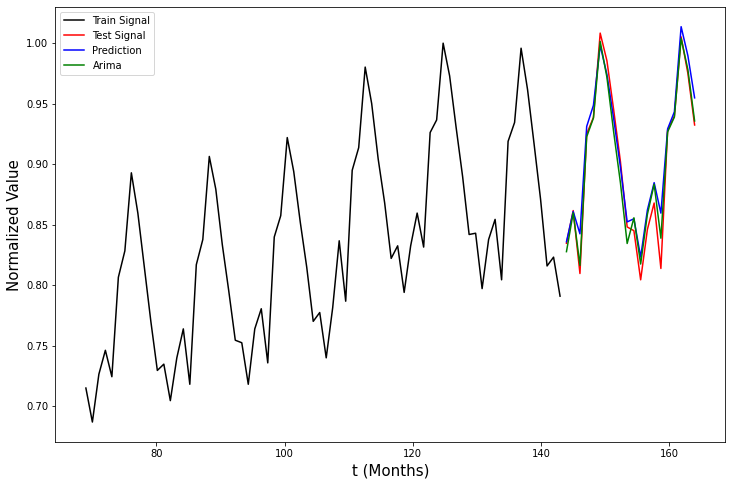

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(L//2,L+n,L//2+n), x[L//2:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (Months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'smape'))
print("The MAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'mape'))

error_smape = 0
error_mape = 0

for i in range(n_steps-2):
  error_smape += sMAPE(y_sarima[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)
  error_mape += MAPE(y_sarima[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)
  
print("The sMAPE error for the ARIMA method is:", error_smape)
print("The MAPE error for the ARIMA method is:", error_mape)

The sMAPE error for the NBeats method is: 1.4424270268288748
The MAPE error for the NBeats method is: 1.458117721198142
The sMAPE error for the ARIMA method is: 0.9472606656416122
The MAPE error for the ARIMA method is: 0.9487698043995023


#### Beer

In [ ]:
y_sarima = []
model = SARIMAX(x[:L], order=(5,1,0), seasonal_order = (2,1,0,12))
model_fit = model.fit(disp=0)
temp = model_fit.forecast(steps = n)
y_sarima.append(temp)

for i in range(n_steps-1):
  model_fit = model_fit.append(x[L+i*n:L+(i+1)*n])
  temp = model_fit.forecast(steps=n)
  y_sarima.append(temp)

y_sarima = np.array(y_sarima).flatten()[n:]

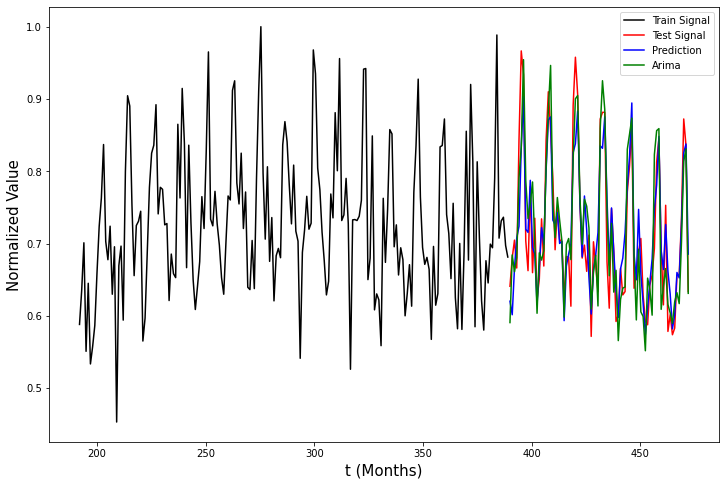

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(L//2,L+n,L//2+n), x[L//2:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (Months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'smape'))
print("The MAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'mape'))

error_smape = 0
error_mape = 0

for i in range(n_steps-2):
  error_smape += sMAPE(y_sarima[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)
  error_mape += MAPE(y_sarima[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)
  
print("The sMAPE error for the ARIMA method is:", error_smape)
print("The MAPE error for the ARIMA method is:", error_mape)

The sMAPE error for the NBeats method is: 4.8708612496384465
The MAPE error for the NBeats method is: 4.9135138932166145
The sMAPE error for the ARIMA method is: 5.368222511932109
The MAPE error for the ARIMA method is: 5.4054507674314864


#### Electric

In [ ]:
y_sarima = []
model = SARIMAX(x[:L], order=(5,1,0), seasonal_order = (2,1,0,12))
model_fit = model.fit(disp=0)
temp = model_fit.forecast(steps = n)
y_sarima.append(temp)

for i in range(n_steps-1):
  model_fit = model_fit.append(x[L+i*n:L+(i+1)*n])
  temp = model_fit.forecast(steps=n)
  y_sarima.append(temp)

y_sarima = np.array(y_sarima).flatten()[n:]

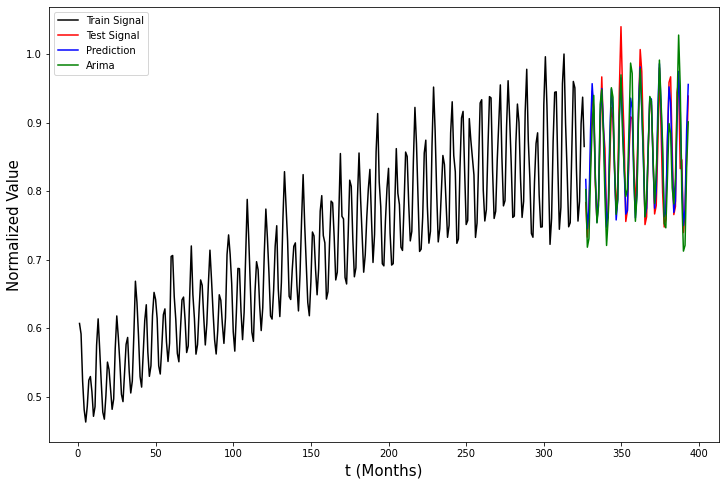

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L+n,L+n), x[:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (Months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'smape'))
print("The MAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'mape'))

error_smape = 0
error_mape = 0

for i in range(n_steps-2):
  error_smape += sMAPE(y_sarima[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)
  error_mape += MAPE(y_sarima[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)
  
print("The sMAPE error for the ARIMA method is:", error_smape)
print("The MAPE error for the ARIMA method is:", error_mape)

The sMAPE error for the NBeats method is: 2.410761207552203
The MAPE error for the NBeats method is: 2.4122132531851537
The sMAPE error for the ARIMA method is: 3.420216179645778
The MAPE error for the ARIMA method is: 3.425522889514781


####M4-M21000


In [ ]:
model = SARIMAX(x_tr, order=(5,1,0), seasonal_order = (2,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

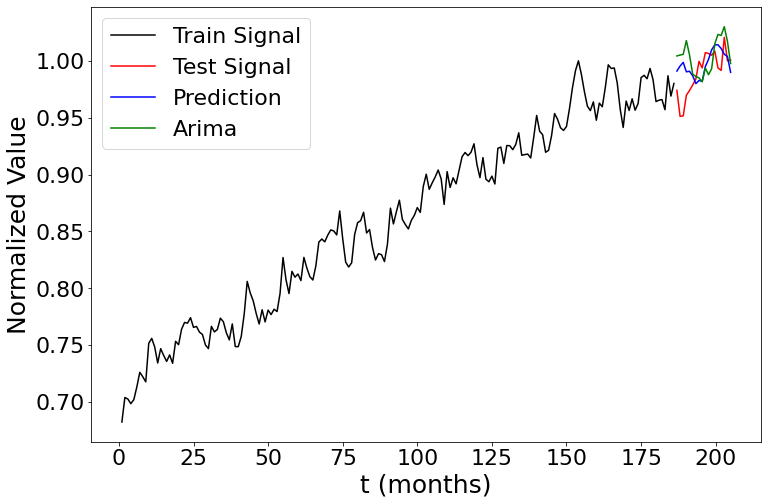

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 2.07050558998007
The MAPE error for the NBeats method is: 2.107747739406916
The sMAPE error for the ARIMA method is: 2.216682123606733
The MAPE error for the ARIMA method is: 2.2496992549437684


####M4-M21001


In [ ]:
model = SARIMAX(x_tr, order=(5,1,0), seasonal_order = (2,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

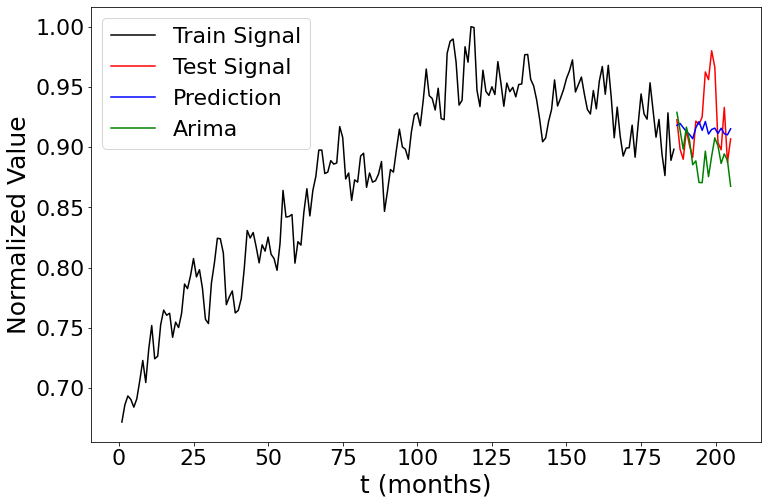

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 2.267147313722183
The MAPE error for the NBeats method is: 2.241349594921319
The sMAPE error for the ARIMA method is: 3.4315219456622748
The MAPE error for the ARIMA method is: 3.3327776576275374


####M4-M21002


In [ ]:
model = SARIMAX(x_tr, order=(5,1,0), seasonal_order = (2,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

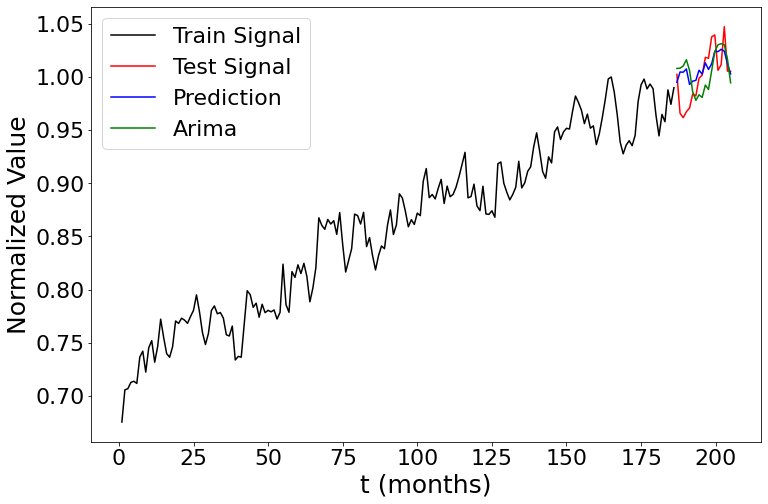

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 1.7078908628473075
The MAPE error for the NBeats method is: 1.7223980238269134
The sMAPE error for the ARIMA method is: 2.27291077959373
The MAPE error for the ARIMA method is: 2.288219314754426


####M4-M21003


In [ ]:
model = SARIMAX(x_tr, order=(5,1,0), seasonal_order = (2,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

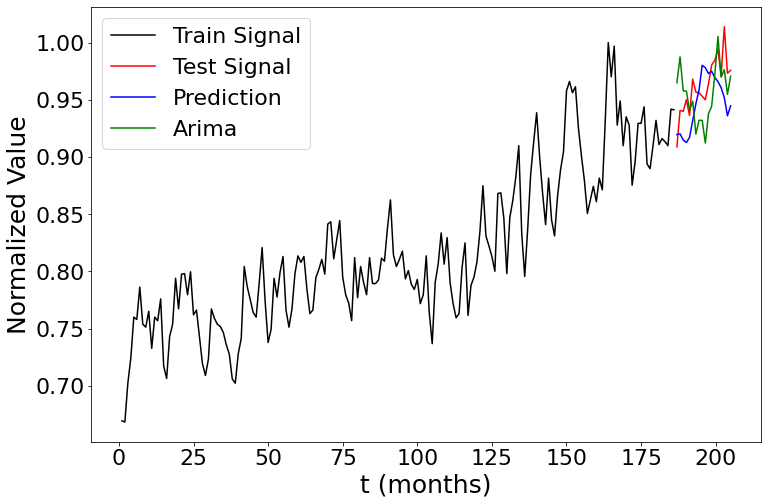

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 2.409157263409553
The MAPE error for the NBeats method is: 2.3802103571029987
The sMAPE error for the ARIMA method is: 2.44507837792998
The MAPE error for the ARIMA method is: 2.4393076311665745


####M4-M21004


In [ ]:
model = SARIMAX(x_tr, order=(5,1,0), seasonal_order = (2,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

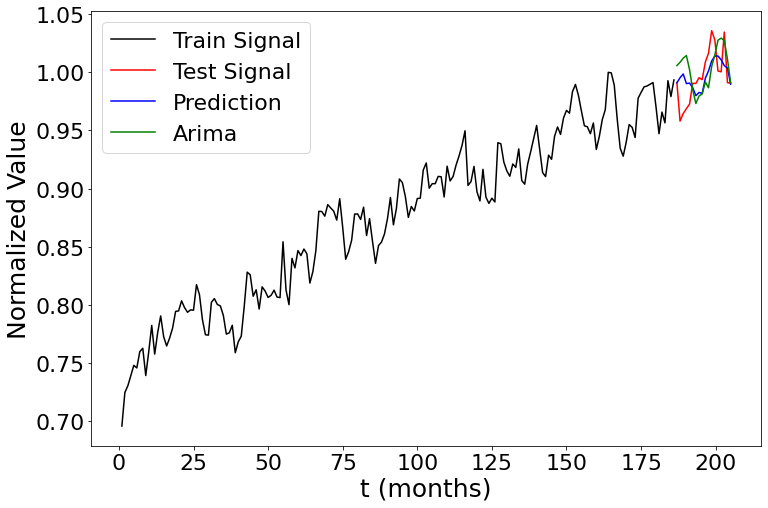

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 1.5885652577223512
The MAPE error for the NBeats method is: 1.5927453800133078
The sMAPE error for the ARIMA method is: 2.299943001482831
The MAPE error for the ARIMA method is: 2.3202631536108322


####M4-M200


In [ ]:
model = SARIMAX(x_tr, order=(5,1,1), seasonal_order = (3,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

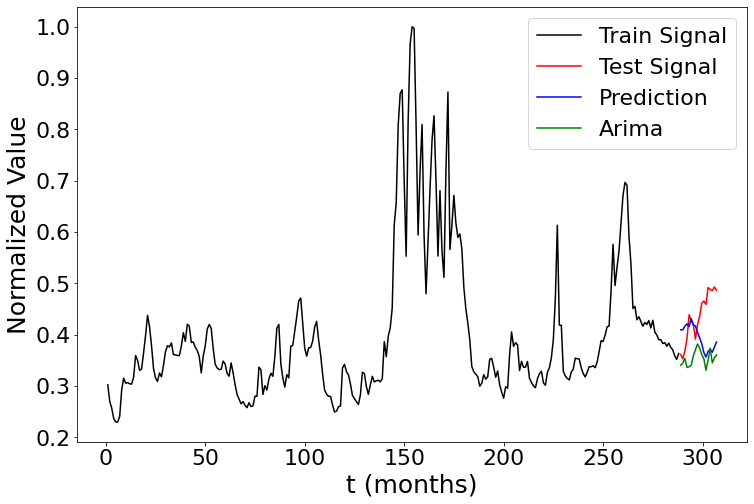

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 15.325024101439007
The MAPE error for the NBeats method is: 14.190857062166916
The sMAPE error for the ARIMA method is: 20.208694426732823
The MAPE error for the ARIMA method is: 17.908394825948918


####M4-M500


In [ ]:
model = SARIMAX(x_tr, order=(5,1,1), seasonal_order = (3,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

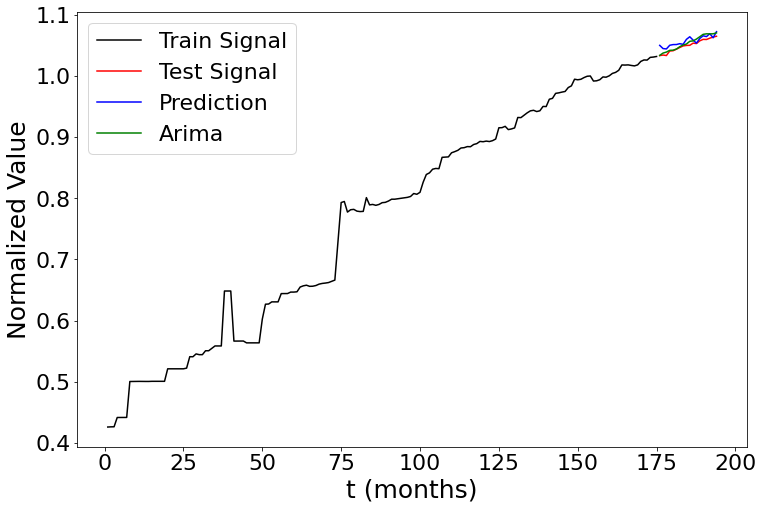

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 0.7086597403491139
The MAPE error for the NBeats method is: 0.7119585231732953
The sMAPE error for the ARIMA method is: 0.40029811467158527
The MAPE error for the ARIMA method is: 0.401469225798079


####M4-M2000


In [ ]:
model = SARIMAX(x_tr, order=(5,1,1), seasonal_order = (3,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


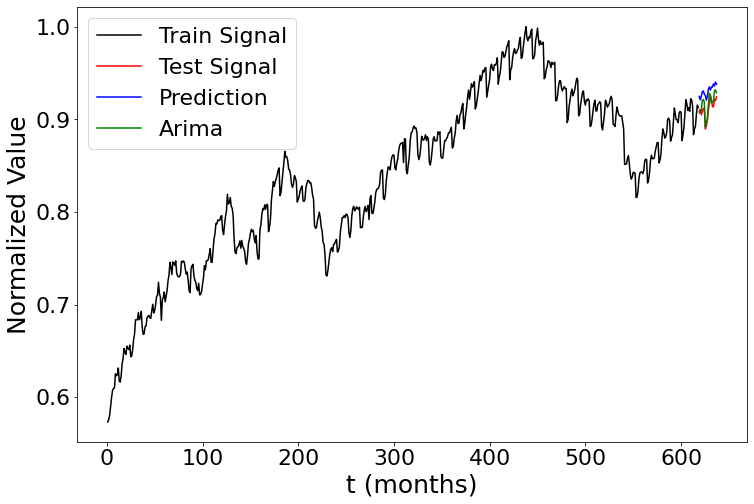

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 2.0920450293313717
The MAPE error for the NBeats method is: 2.117148907592678
The sMAPE error for the ARIMA method is: 0.6429585469734769
The MAPE error for the ARIMA method is: 0.6454746933427452


####M4-M4000


In [ ]:
model = SARIMAX(x_tr, order=(5,1,1), seasonal_order = (3,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

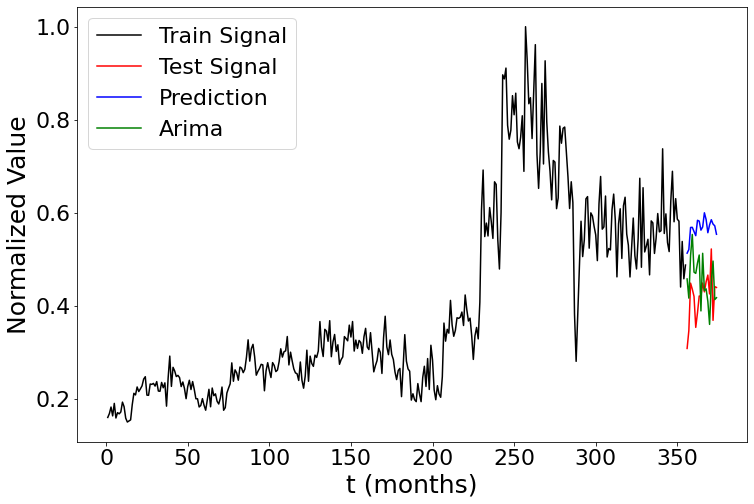

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 30.419542549708673
The MAPE error for the NBeats method is: 36.65873171541803
The sMAPE error for the ARIMA method is: 15.936632360124907
The MAPE error for the ARIMA method is: 17.506609156152532


####M4-M12000


In [ ]:
model = SARIMAX(x_tr, order=(5,1,1), seasonal_order = (3,1,0,12))
model_fit = model.fit(disp=0)
y_sarima = model_fit.forecast(steps = n)

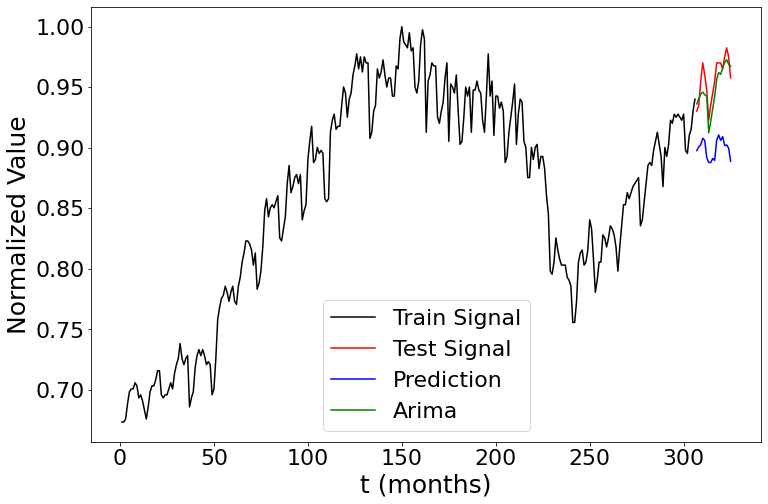

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_sarima,'g', label = 'Arima')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ARIMA method is:", sMAPE(y_sarima,y_te))
print("The MAPE error for the ARIMA method is:", MAPE(y_sarima,y_te))

The sMAPE error for the NBeats method is: 6.184177242459806
The MAPE error for the NBeats method is: 5.9898660324488775
The sMAPE error for the ARIMA method is: 1.043792854447798
The MAPE error for the ARIMA method is: 1.0378992477112194


### Exponential Model

#### Milk

In [ ]:
y_holtwinters = []
for i in range(n_steps):
  model = ExponentialSmoothing(x[:L+i*n], seasonal_periods=12, trend='add', seasonal='add', damped=True)
  model_fit = model.fit(use_boxcox=True)
  temp = model_fit.forecast(steps = n)
  y_holtwinters.append(temp)
y_holtwinters = np.array(y_holtwinters).flatten()[n:]

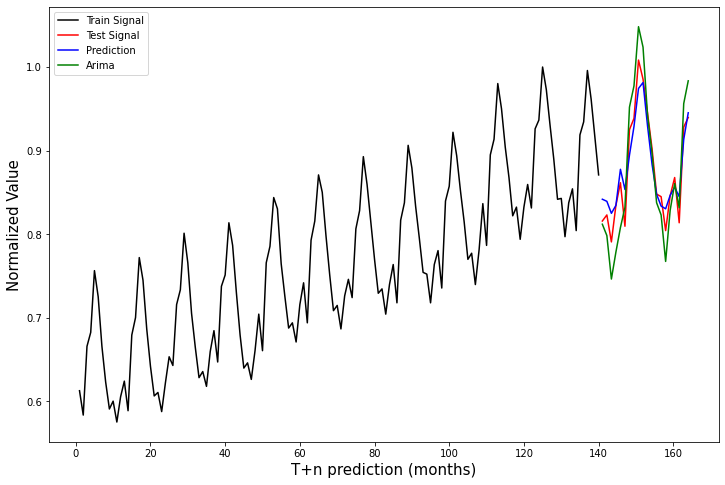

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(L//2,L+n,L//2+n), x[L//2:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (Months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

In [ ]:
error_holt = 0 
for i in range(n_steps-2):
  error_holt += MAPE(y_holtwinters[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)

print("The MAPE error for the ETS method is:" , error_holt)
print("The MAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'mape'))
print("The MAPE error for the ARIMA method is:", error_mape)

The MAPE error for the ETS method is: 2.449828195549185
The MAPE error for the NBeats method is: 1.5933485301990353
The MAPE error for the ARIMA method is: 0.4855466703497139


#### Beer

In [ ]:
y_holtwinters = []
for i in range(n_steps):
  model = ExponentialSmoothing(x[:L+i*n], seasonal_periods=12, trend='add', seasonal='add', damped=True)
  model_fit = model.fit(use_boxcox=True)
  temp = model_fit.forecast(steps = n)
  y_holtwinters.append(temp)
y_holtwinters = np.array(y_holtwinters).flatten()[n:]

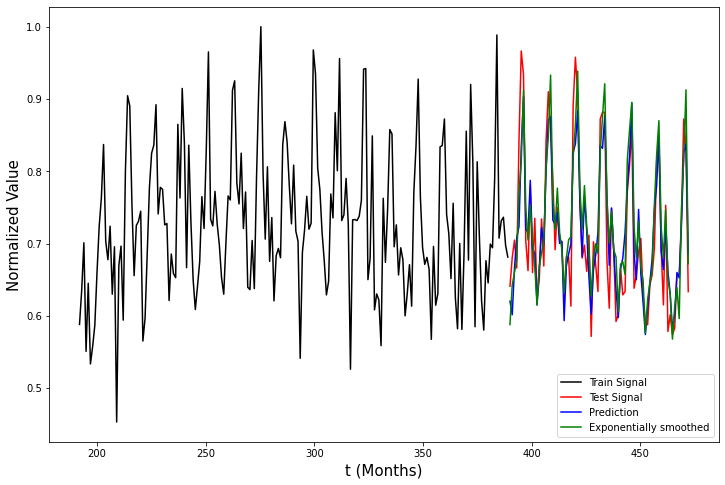

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(L//2,L+n,L//2+n), x[L//2:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_holtwinters,'g', label = 'Exponentially smoothed')
plt.legend()
plt.xlabel('t (Months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

In [ ]:
error_holt = 0 
error_holt2 = 0 

for i in range(n_steps-2):
  error_holt += MAPE(y_holtwinters[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)
  error_holt2 += sMAPE(y_holtwinters[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)

print("The MAPE error for the ETS method is:" , error_holt)
print("The sMAPE error for the ETS method is:" , error_holt2)
print("The MAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'mape'))
print("The sMAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'smape'))

The MAPE error for the ETS method is: 5.115593032573025
The sMAPE error for the ETS method is: 5.0306290791391595
The MAPE error for the NBeats method is: 4.9135138932166145
The sMAPE error for the NBeats method is: 4.8708612496384465


#### Electric

In [ ]:
y_holtwinters = []
for i in range(n_steps):
  model = ExponentialSmoothing(x[:L+i*n], seasonal_periods=12, trend='add', seasonal='add', damped=True)
  model_fit = model.fit(use_boxcox=True)
  temp = model_fit.forecast(steps = n)
  y_holtwinters.append(temp)
y_holtwinters = np.array(y_holtwinters).flatten()[n:]

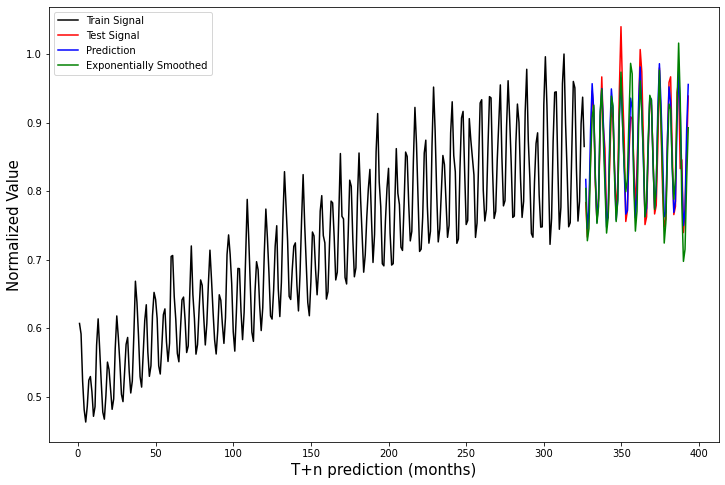

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L+n,L+n), x[:L+n], 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)), y,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1+n,L+1+len(x[L+n:]),len(y)),y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('T+n prediction (months)', size=15)
plt.ylabel('Normalized Value', size=15)
plt.show()

In [ ]:
error_holt = 0 
for i in range(n_steps-2):
  error_holt += MAPE(y_holtwinters[i*n:(i+1)*n],y[i*n:(i+1)*n])/(n_steps-1)

print("The MAPE error for the ETS method is:" , error_holt)
print("The MAPE error for the NBeats method is:", getAvgError(p[n:],test_data[n:],'mape'))
print("The MAPE error for the ARIMA method is:", error_mape)

The MAPE error for the ETS method is: 3.0549308270996876
The MAPE error for the NBeats method is: 2.4122132531851537
The MAPE error for the ARIMA method is: 3.425522889514781


#### M4-M21000

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

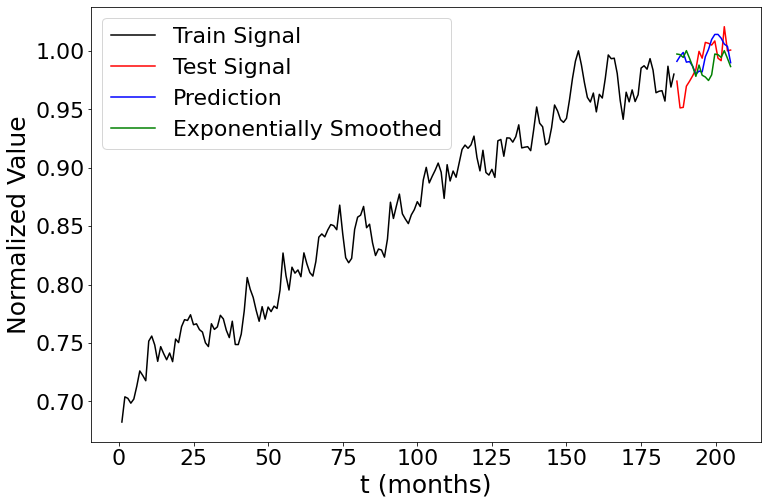

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 2.07050558998007
The MAPE error for the NBeats method is: 2.107747739406916
The sMAPE error for the ETS method is: 1.9516235247216607
The MAPE error for the ETS method is: 1.9586322849351359


#### M4-M21001

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

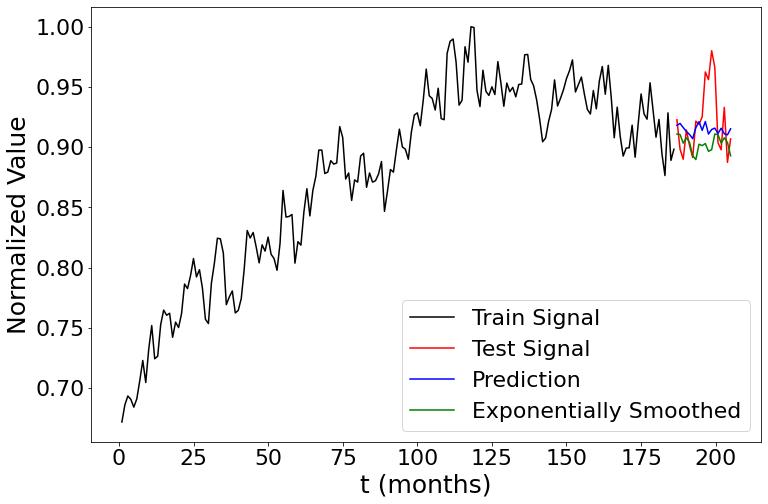

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 2.267147313722183
The MAPE error for the NBeats method is: 2.241349594921319
The sMAPE error for the ETS method is: 2.6779157110424876
The MAPE error for the ETS method is: 2.618982420730225


#### M4-M21002

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

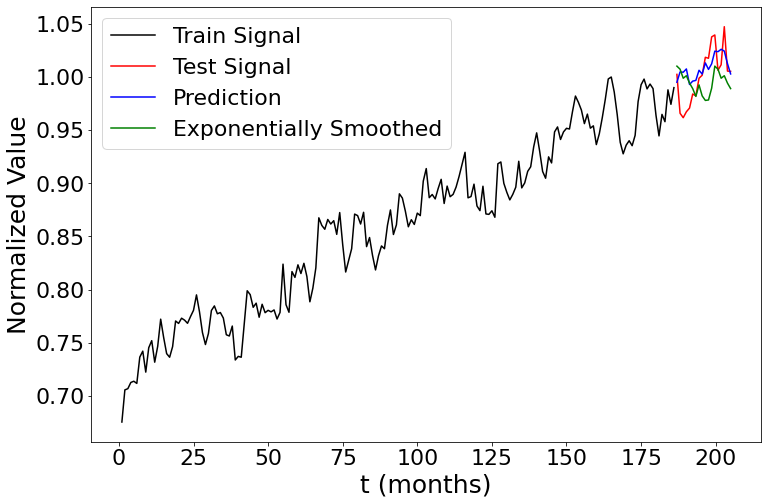

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 1.7078908628473075
The MAPE error for the NBeats method is: 1.7223980238269134
The sMAPE error for the ARIMA method is: 2.332849546306853
The MAPE error for the ARIMA method is: 2.321836533472217


#### M4-M21003

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

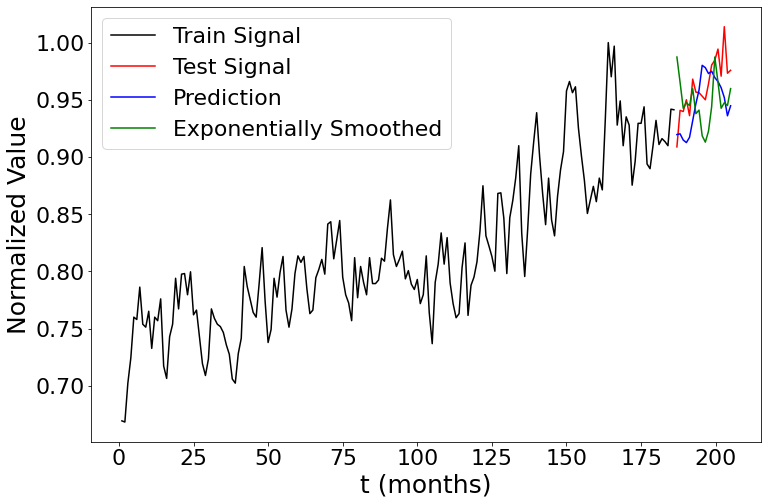

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 2.409157263409553
The MAPE error for the NBeats method is: 2.3802103571029987
The sMAPE error for the ETS method is: 2.791523141023958
The MAPE error for the ETS method is: 2.7741503925942075


#### M4-M21004

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

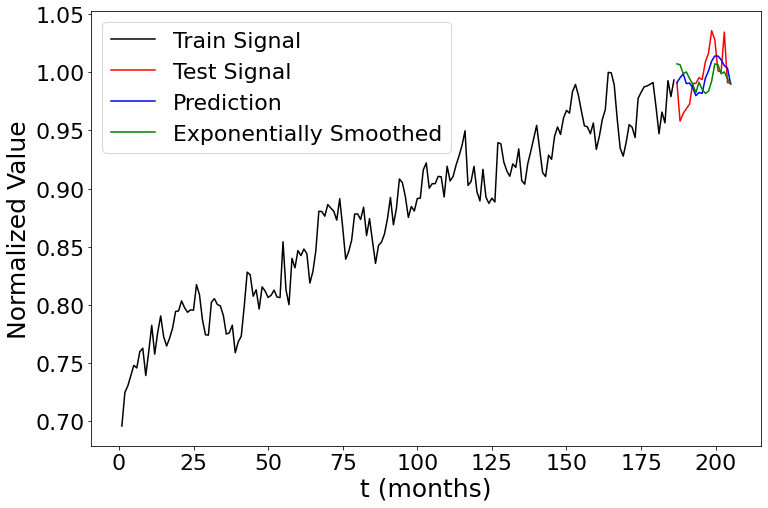

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 1.5885652577223512
The MAPE error for the NBeats method is: 1.5927453800133078
The sMAPE error for the ETS method is: 1.9087896297803668
The MAPE error for the ETS method is: 1.9097437592257536


#### M4-M200

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

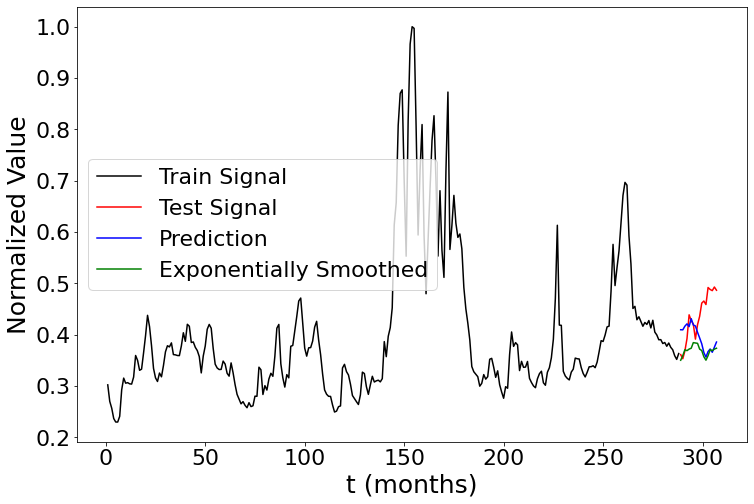

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 15.325024101439007
The MAPE error for the NBeats method is: 14.190857062166916
The sMAPE error for the ETS method is: 16.27637673677877
The MAPE error for the ETS method is: 14.6078115873471


#### M4-M500

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

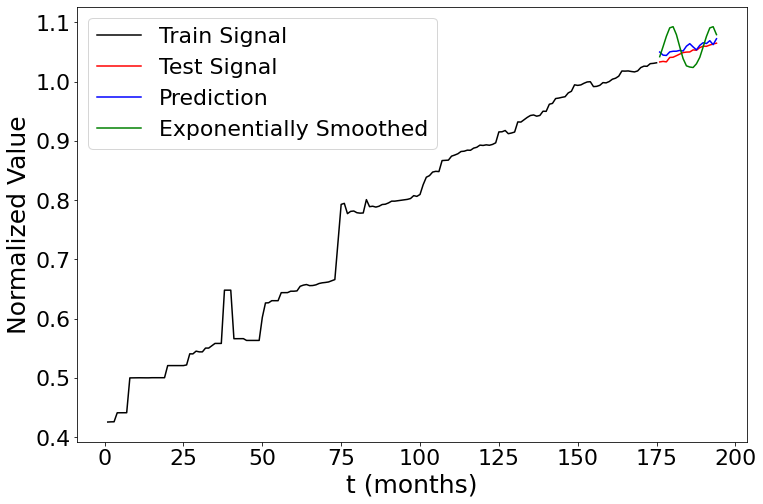

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 0.7086597403491139
The MAPE error for the NBeats method is: 0.7119585231732953
The sMAPE error for the ETS method is: 2.335983542841472
The MAPE error for the ETS method is: 2.3567134544726023


#### M4-M2000

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

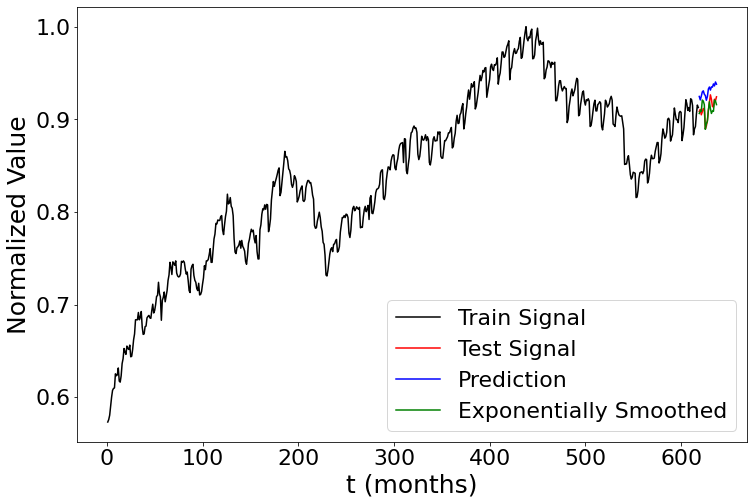

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 2.0920450293313717
The MAPE error for the NBeats method is: 2.117148907592678
The sMAPE error for the ETS method is: 0.5338490419075832
The MAPE error for the ETS method is: 0.5328512493851271


#### M4-M4000

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

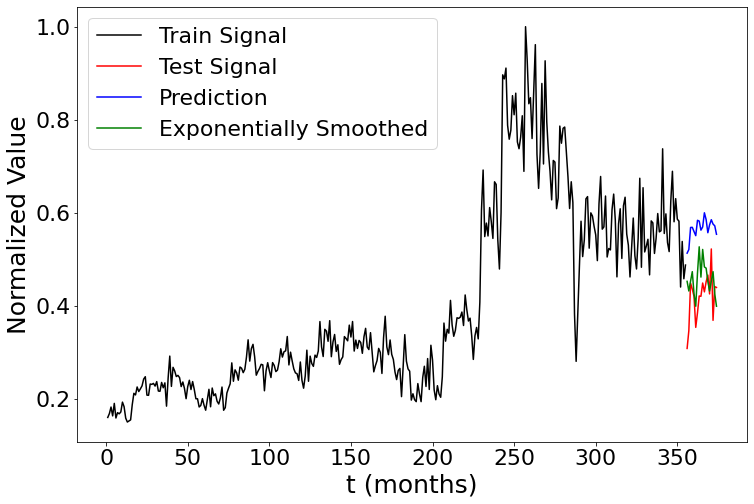

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 30.419542549708673
The MAPE error for the NBeats method is: 36.65873171541803
The sMAPE error for the ETS method is: 12.40778467025429
The MAPE error for the ETS method is: 13.646463780839174


#### M4-M12000

In [ ]:
model = ExponentialSmoothing(x_tr, seasonal_periods=12, trend='add', seasonal='add', damped=True)
model_fit = model.fit(use_boxcox=True)
y_holtwinters = model_fit.forecast(steps = n)

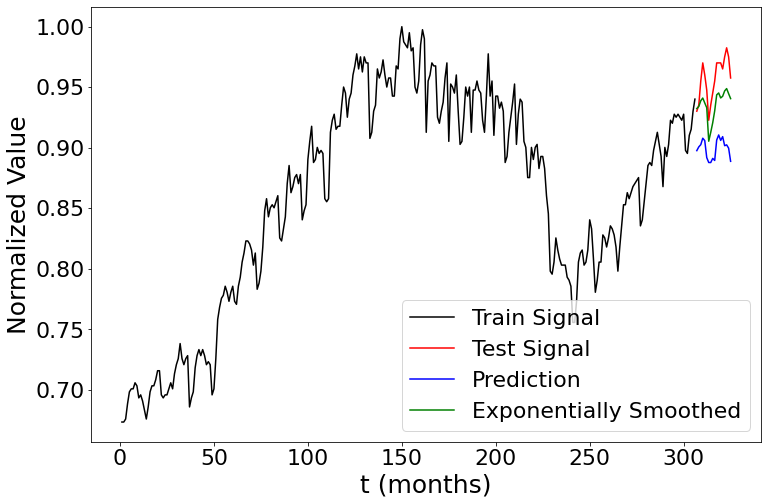

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.linspace(1,L,L), x_tr, 'k', label = 'Train Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_te,'r', label = 'Test Signal')
plt.plot(np.linspace(L+1,L+1+n,n), y_pred,'b', label = 'Prediction')
plt.plot(np.linspace(L+1,L+1+n,n), y_holtwinters,'g', label = 'Exponentially Smoothed')
plt.legend()
plt.xlabel('t (months)', size=25)
plt.ylabel('Normalized Value', size=25)
plt.show()

In [ ]:
print("The sMAPE error for the NBeats method is:", sMAPE(y_pred,y_te))
print("The MAPE error for the NBeats method is:", MAPE(y_pred,y_te))  
print("The sMAPE error for the ETS method is:", sMAPE(y_holtwinters,y_te))
print("The MAPE error for the ETS method is:", MAPE(y_holtwinters,y_te))

The sMAPE error for the NBeats method is: 6.184177242459806
The MAPE error for the NBeats method is: 5.9898660324488775
The sMAPE error for the ETS method is: 2.2678380145687678
The MAPE error for the ETS method is: 2.238526943718214
